## 1.3 EDA for ASHRAE

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div> 

<div style="text-align: right"> Initial upload: 2022.06.15 </div> 
<div style="text-align: right"> Last update: 2022.06.15</div> 

- https://www.kaggle.com/code/nroman/eda-for-ashrae

### 라이브러리 import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import datetime
import missingno as msno
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 150

In [2]:
import gc

### Loading data

In [3]:
print(os.listdir('data/ashrae-energy-prediction/'))

['building_metadata.csv', 'sample_submission.csv', 'test.csv', 'test_df.pkl', 'train.csv', 'train_df.pkl', 'weather_test.csv', 'weather_train.csv']


In [4]:
%%time
root = 'data/ashrae-energy-prediction/'

train = pd.read_csv(root +'train.csv')
weather_train = pd.read_csv(root + 'weather_train.csv')
test = pd.read_csv(root + 'test.csv')
weather_test = pd.read_csv(root + 'weather_test.csv')
building = pd.read_csv(root + 'building_metadata.csv')

CPU times: total: 11.7 s
Wall time: 11.7 s


In [5]:
train.head()

building_id  meter            timestamp  meter_reading
0            0      0  2016-01-01 00:00:00            0.0
1            1      0  2016-01-01 00:00:00            0.0
2            2      0  2016-01-01 00:00:00            0.0
3            3      0  2016-01-01 00:00:00            0.0
4            4      0  2016-01-01 00:00:00            0.0

In [6]:
train['building_id'].unique()

array([  0,   1,   2, ..., 591, 783, 403], dtype=int64)

In [7]:
building.head()

site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432      2008.0          NaN
1        0            1   Education         2720      2004.0          NaN
2        0            2   Education         5376      1991.0          NaN
3        0            3   Education        23685      2002.0          NaN
4        0            4   Education       116607      1975.0          NaN

In [8]:
building['building_id'].unique()

array([   0,    1,    2, ..., 1446, 1447, 1448], dtype=int64)

In [9]:
weather_train.head()

site_id            timestamp  air_temperature  cloud_coverage  \
0        0  2016-01-01 00:00:00             25.0             6.0   
1        0  2016-01-01 01:00:00             24.4             NaN   
2        0  2016-01-01 02:00:00             22.8             2.0   
3        0  2016-01-01 03:00:00             21.1             2.0   
4        0  2016-01-01 04:00:00             20.0             2.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             20.0                NaN              1019.7             0.0   
1             21.1               -1.0              1020.2            70.0   
2             21.1                0.0              1020.2             0.0   
3             20.6                0.0              1020.1             0.0   
4             20.0               -1.0              1020.0           250.0   

   wind_speed  
0         0.0  
1         1.5  
2         0.0  
3         0.0  
4         2.6

merging

In [10]:
train = train.merge(building, on = 'building_id', how='left')
test = test.merge(building, on = 'building_id', how='left')

train = train.merge(weather_train, on = ['site_id', 'timestamp'], how = 'left')
test = test.merge(weather_test, on = ['site_id', 'timestamp'], how = 'left')

del weather_train, weather_test, building
gc.collect()

4

용량 줄이기

In [11]:
train.dtypes

building_id             int64
meter                   int64
timestamp              object
meter_reading         float64
site_id                 int64
primary_use            object
square_feet             int64
year_built            float64
floor_count           float64
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
dtype: object

In [12]:
# Saving some memory
d_types = {'building_id': np.int16,
          'meter': np.int8,
          'site_id': np.int8,
          'primary_use': 'category',
          'square_feet': np.int32,
          'year_built': np.float16,
          'floor_count': np.float16,
          'air_temperature': np.float32,
          'cloud_coverage': np.float16,
          'dew_temperature': np.float32,
          'precip_depth_1_hr': np.float16,
          'sea_level_pressure': np.float32,
          'wind_direction': np.float16,
          'wind_speed': np.float32}

for feature in d_types:
    train[feature] = train[feature].astype(d_types[feature])
    test[feature] = test[feature].astype(d_types[feature])
    
train["timestamp"] = pd.to_datetime(train["timestamp"])
test["timestamp"] = pd.to_datetime(test["timestamp"])
gc.collect();

결측치 확인

In [13]:
train.shape

(20216100, 16)

In [14]:
train.count()

building_id           20216100
meter                 20216100
timestamp             20216100
meter_reading         20216100
site_id               20216100
primary_use           20216100
square_feet           20216100
year_built             8088455
floor_count            3506933
air_temperature       20119442
cloud_coverage        11390735
dew_temperature       20115960
precip_depth_1_hr     16467077
sea_level_pressure    18984431
wind_direction        18767052
wind_speed            20072424
dtype: int64

In [15]:
train_data = (train.count() / len(train)).drop('meter_reading').sort_values().values

ind = np.arange(len(train_data))
width = 0.35

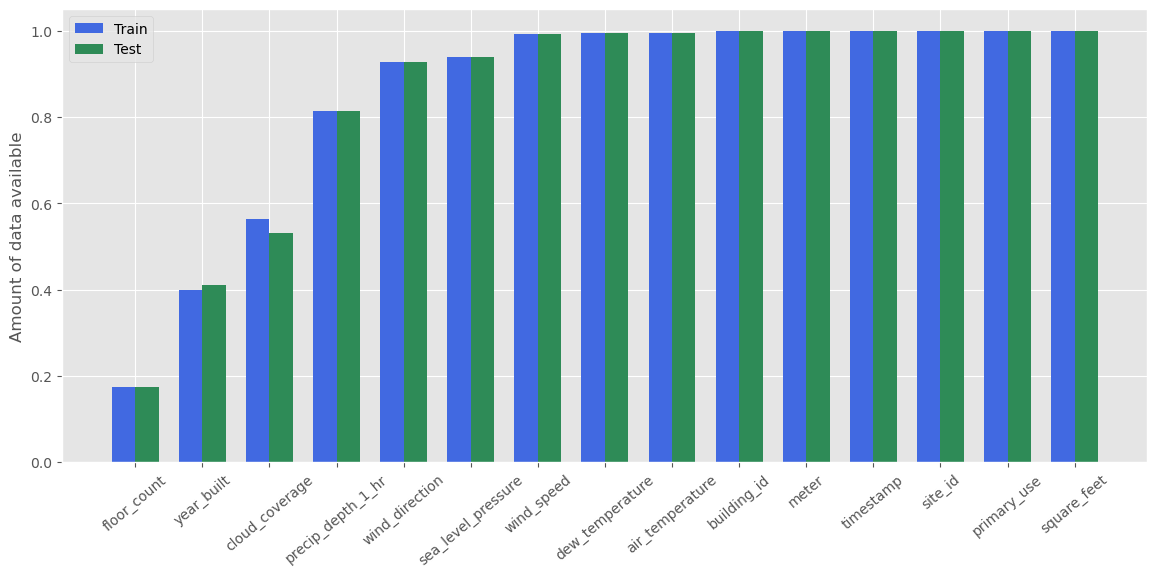

In [16]:
fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(x=ind, height= train_data,width = width, color='royalblue')

test_data = (test.count() / len(test)).drop('row_id').sort_values().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Amount of data available');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels((train.count() / len(train)).drop('meter_reading').sort_values().index, rotation=40)
axes.legend([tr, tt], ['Train', 'Test']);

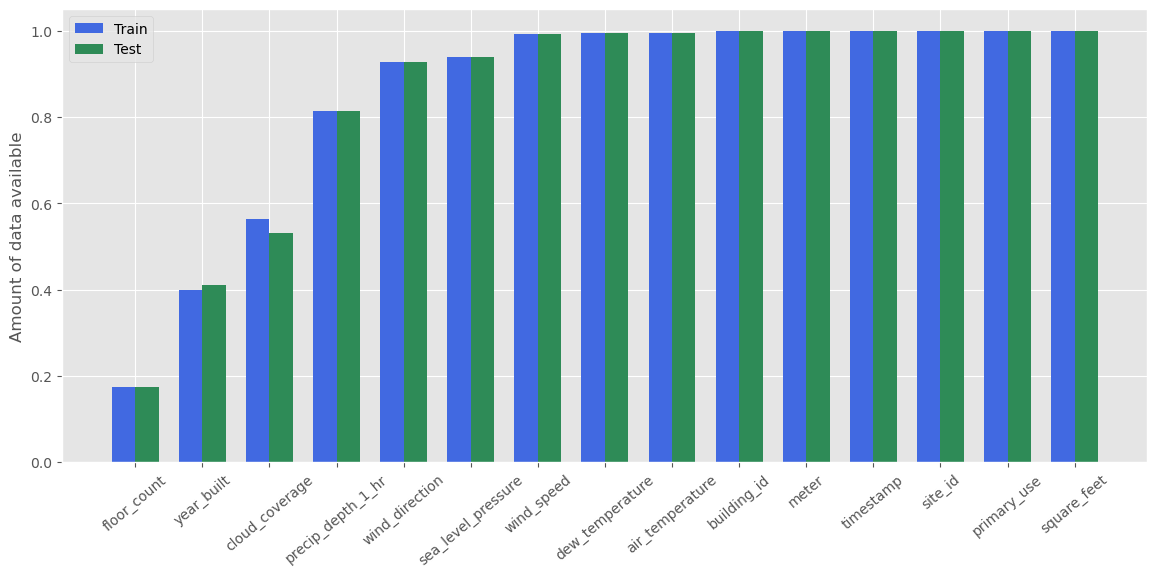

In [17]:
train_data = (train.count() / len(train)).drop('meter_reading').sort_values().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = (test.count() / len(test)).drop('row_id').sort_values().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Amount of data available');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels((train.count() / len(train)).drop('meter_reading').sort_values().index, rotation=40)
axes.legend([tr, tt], ['Train', 'Test']);

- ???

### 일별 평균 미터 리딩

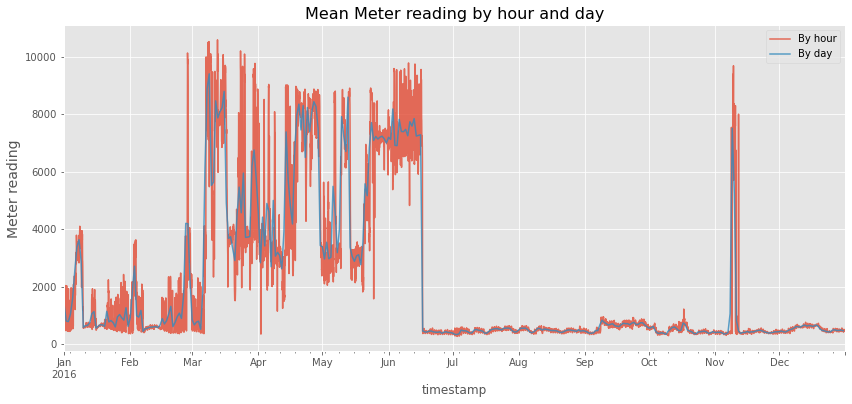

In [18]:
fig, axes = plt.subplots(1, 1, figsize = (14, 6))
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].\
    plot(ax= axes, label = 'By hour', alpha = 0.8).set_ylabel('Meter reading', fontsize = 14)
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].\
    plot(ax= axes, label = 'By day', alpha = 0.8).set_ylabel('Meter reading', fontsize = 14)

axes.set_title('Mean Meter reading by hour and day', fontsize=16);
axes.legend();

- 1~3 월까지 값은 작다. 3 ~ 6월은 값이 커진다. 그리고 6월 이후에는 0가까이 줄어들다가, 11월 근방에 피크 발생

id 별로 평균을 보자.

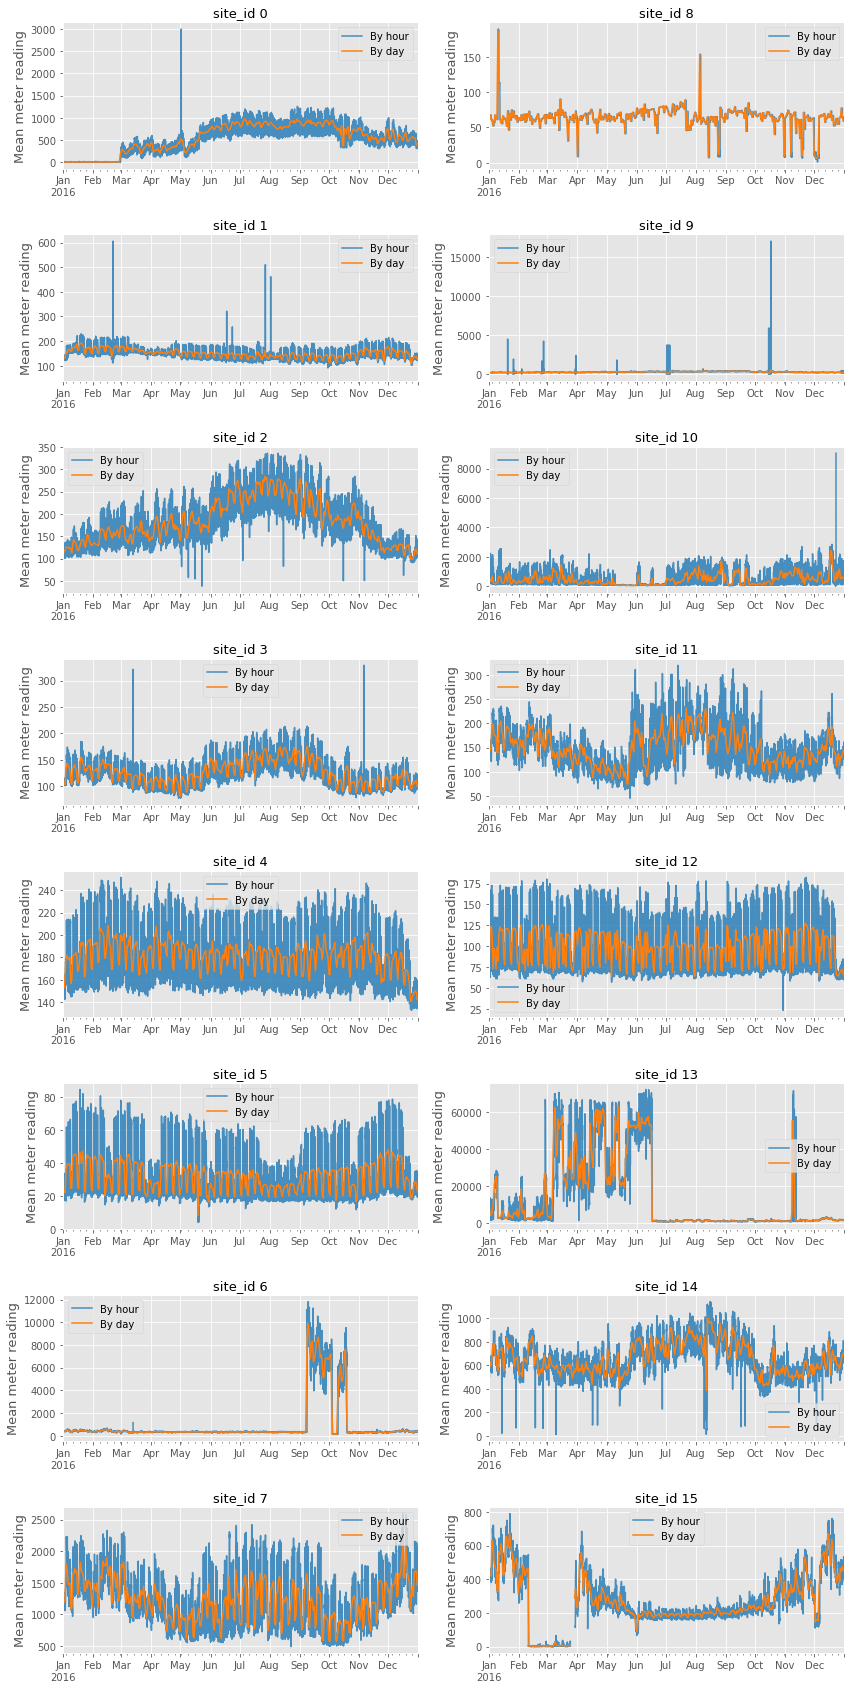

In [19]:
fig, axes = plt.subplots(8, 2, figsize = (14, 30))
for i in range(train['site_id'].nunique()):
    train[train['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].\
        plot(ax= axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    
    train[train['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].\
        plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
    plt.subplots_adjust(hspace=0.45)

- site0은 3월까지 0이다.  
- site13의 영향이 지배적이다.

site==13 중에서 primary use를 살펴보자.

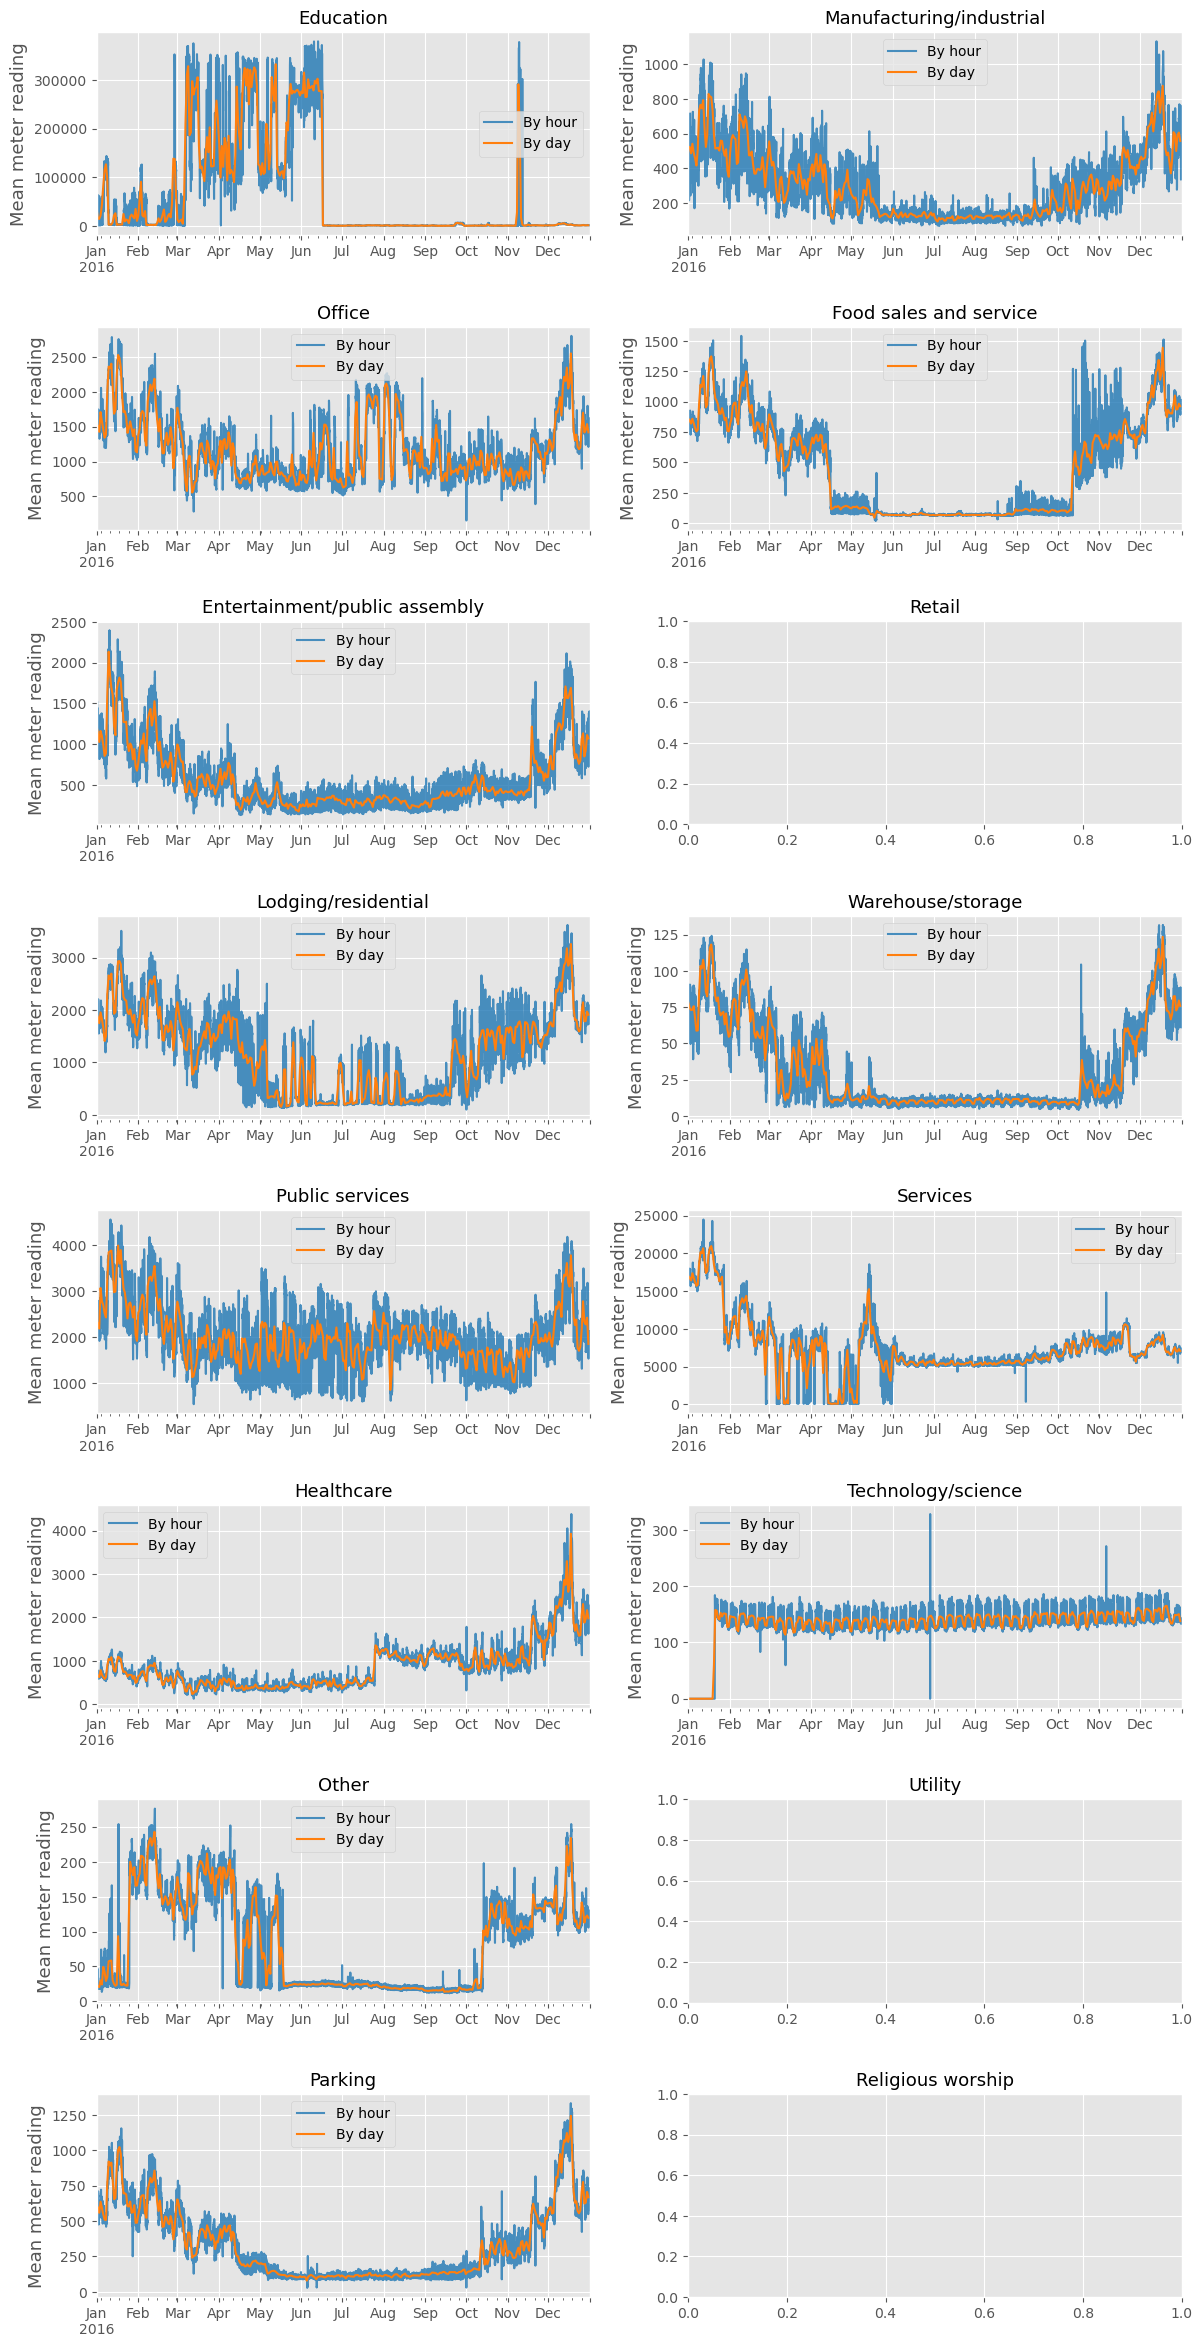

In [20]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i, use in enumerate(train['primary_use'].value_counts().index.to_list()):
    try:
        train[(train['site_id'] == 13) & (train['primary_use'] == use)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
        train[(train['site_id'] == 13) & (train['primary_use'] == use)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange').set_xlabel('');
        axes[i%8][i//8].legend();
    except :
        pass
    axes[i%8][i//8].set_title(use, fontsize=13);
    plt.subplots_adjust(hspace=0.45)

- site_id == 13 and primary_use == Education 결과가 지배적이다.

primary_use==Education and site_id==13의 각 미터 리딩을 살펴보자.

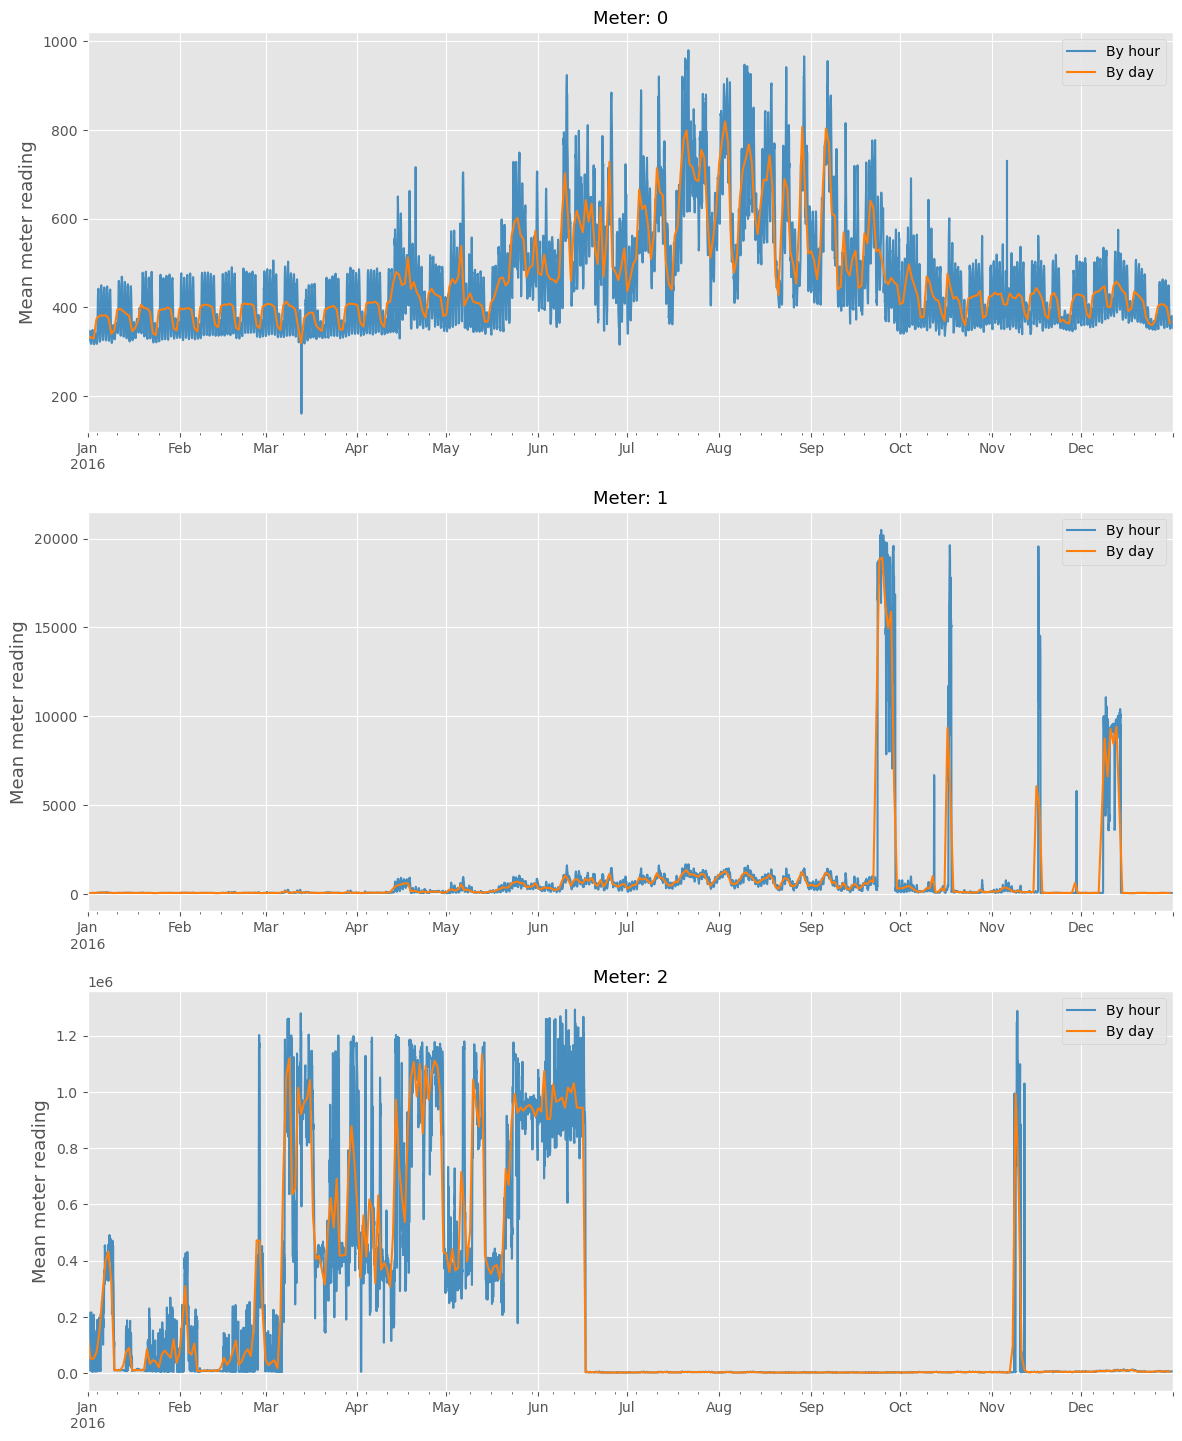

In [21]:
fig, axes = plt.subplots(3,1,figsize=(14, 18), dpi=100)
for i in train[(train['site_id'] == 13) & (train['primary_use'] == 'Education')]['meter'].value_counts(dropna=False).index.to_list():
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i].legend();
    axes[i].set_title('Meter: ' + str(i), fontsize=13);

- site_id 13 with primary_use Education and meter type 2가 지배적이다.

site_id 13 with primary_use Education and meter type 2의 각 빌딩의 차트를 그려보자.

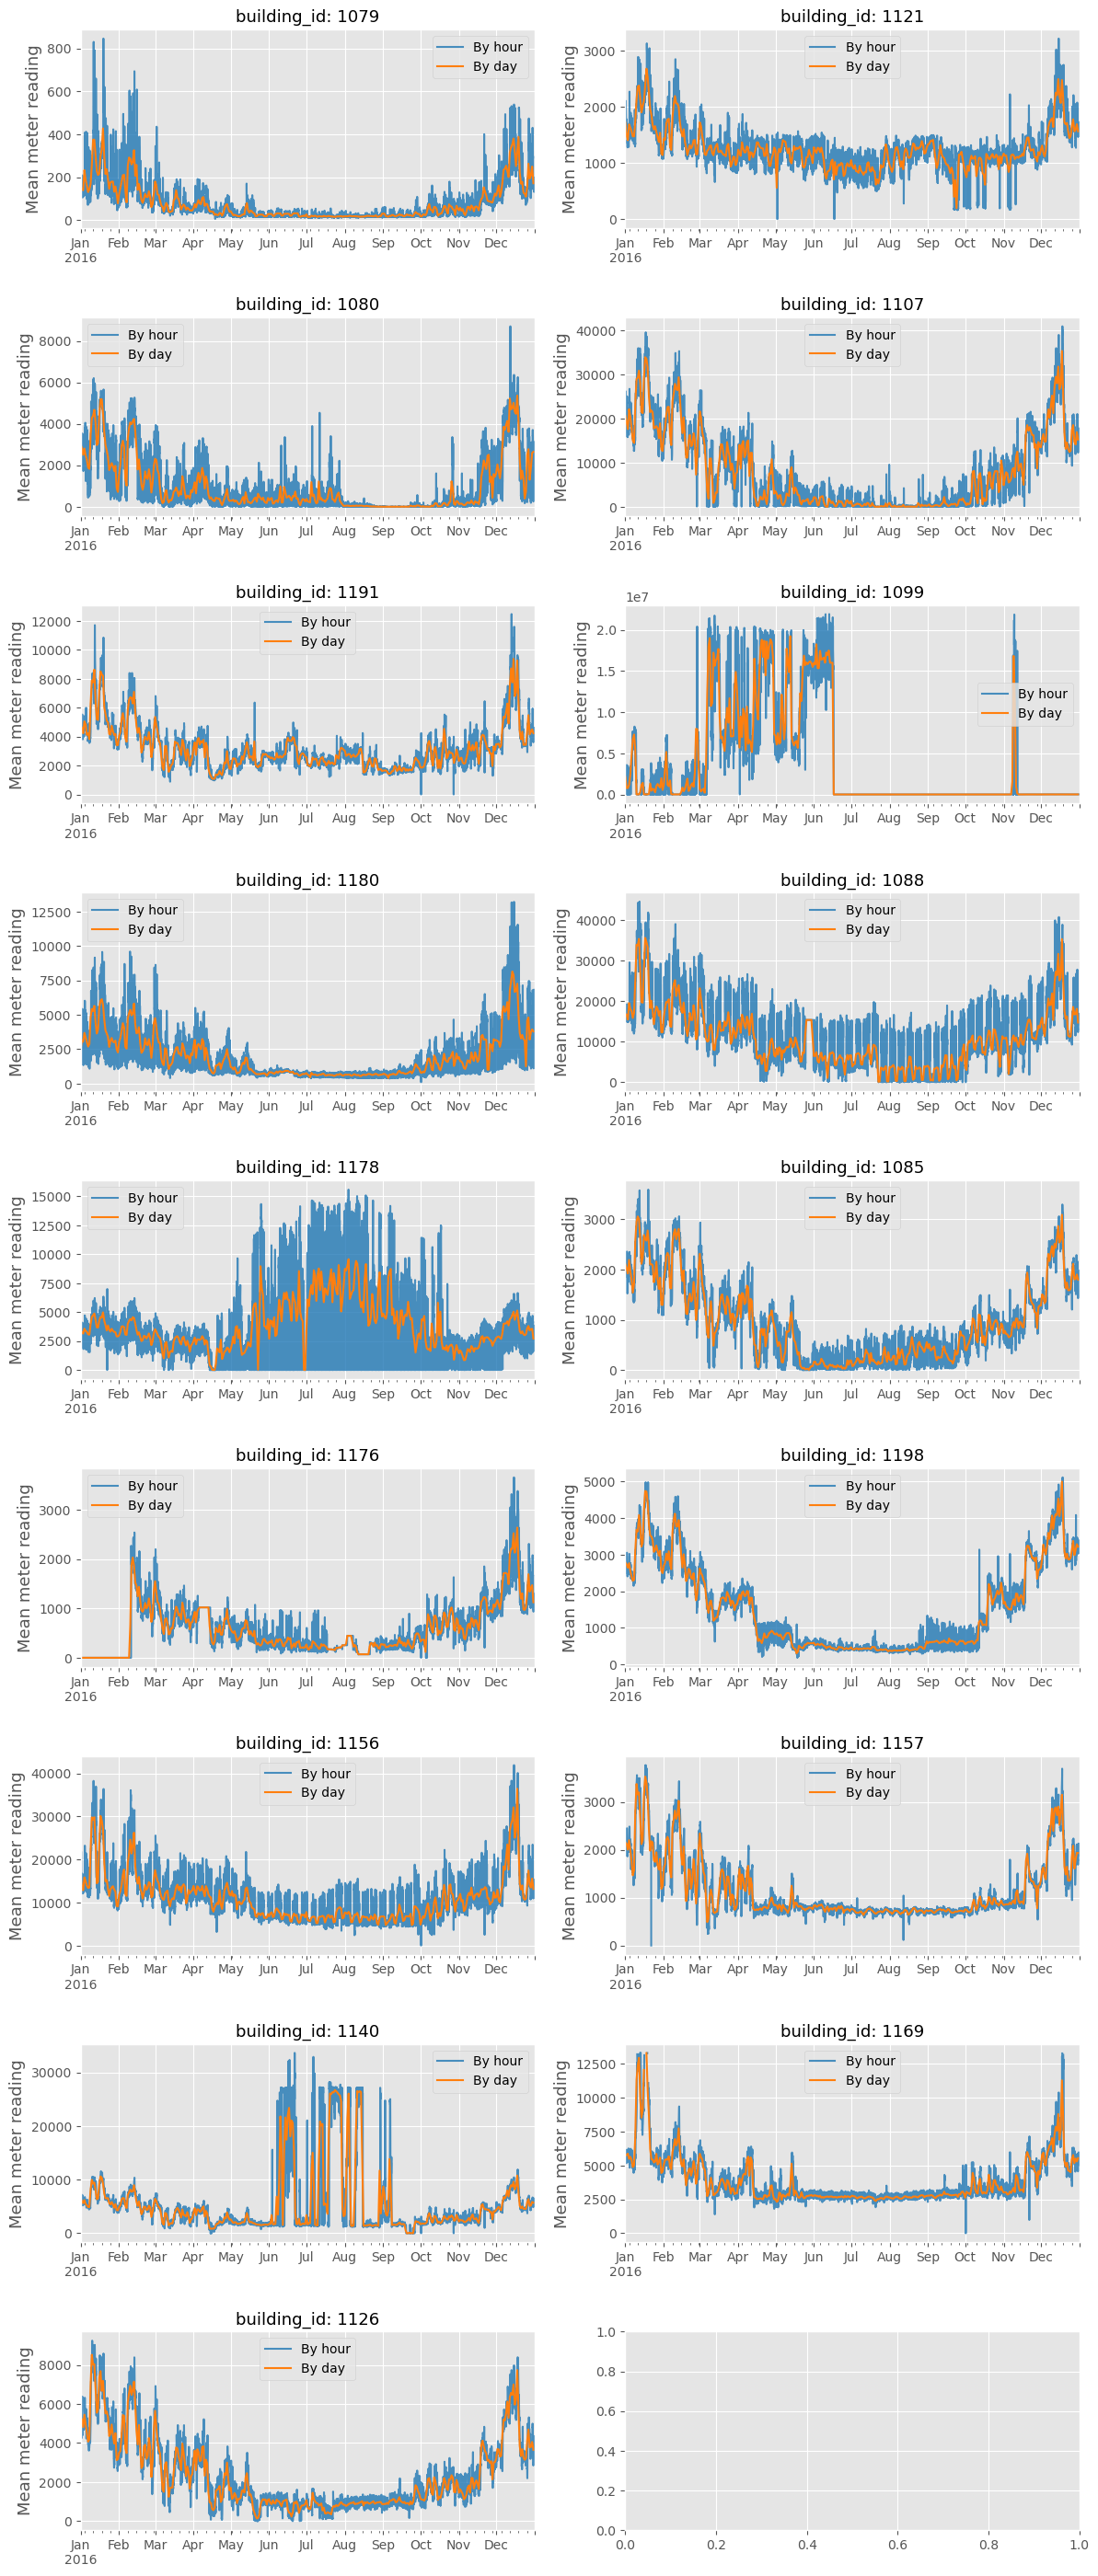

In [22]:
fig, axes = plt.subplots(9,2,figsize=(14, 36), dpi=100)
for i, building in enumerate(train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == 2)]['building_id'].value_counts(dropna=False).index.to_list()):
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == 2) & (train['building_id'] == building)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%9][i//9], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == 2) & (train['building_id'] == building)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%9][i//9], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i%9][i//9].legend();
    axes[i%9][i//9].set_title('building_id: ' + str(building), fontsize=13);
    plt.subplots_adjust(hspace=0.45)

- building_id == 1099가 지배적이다.

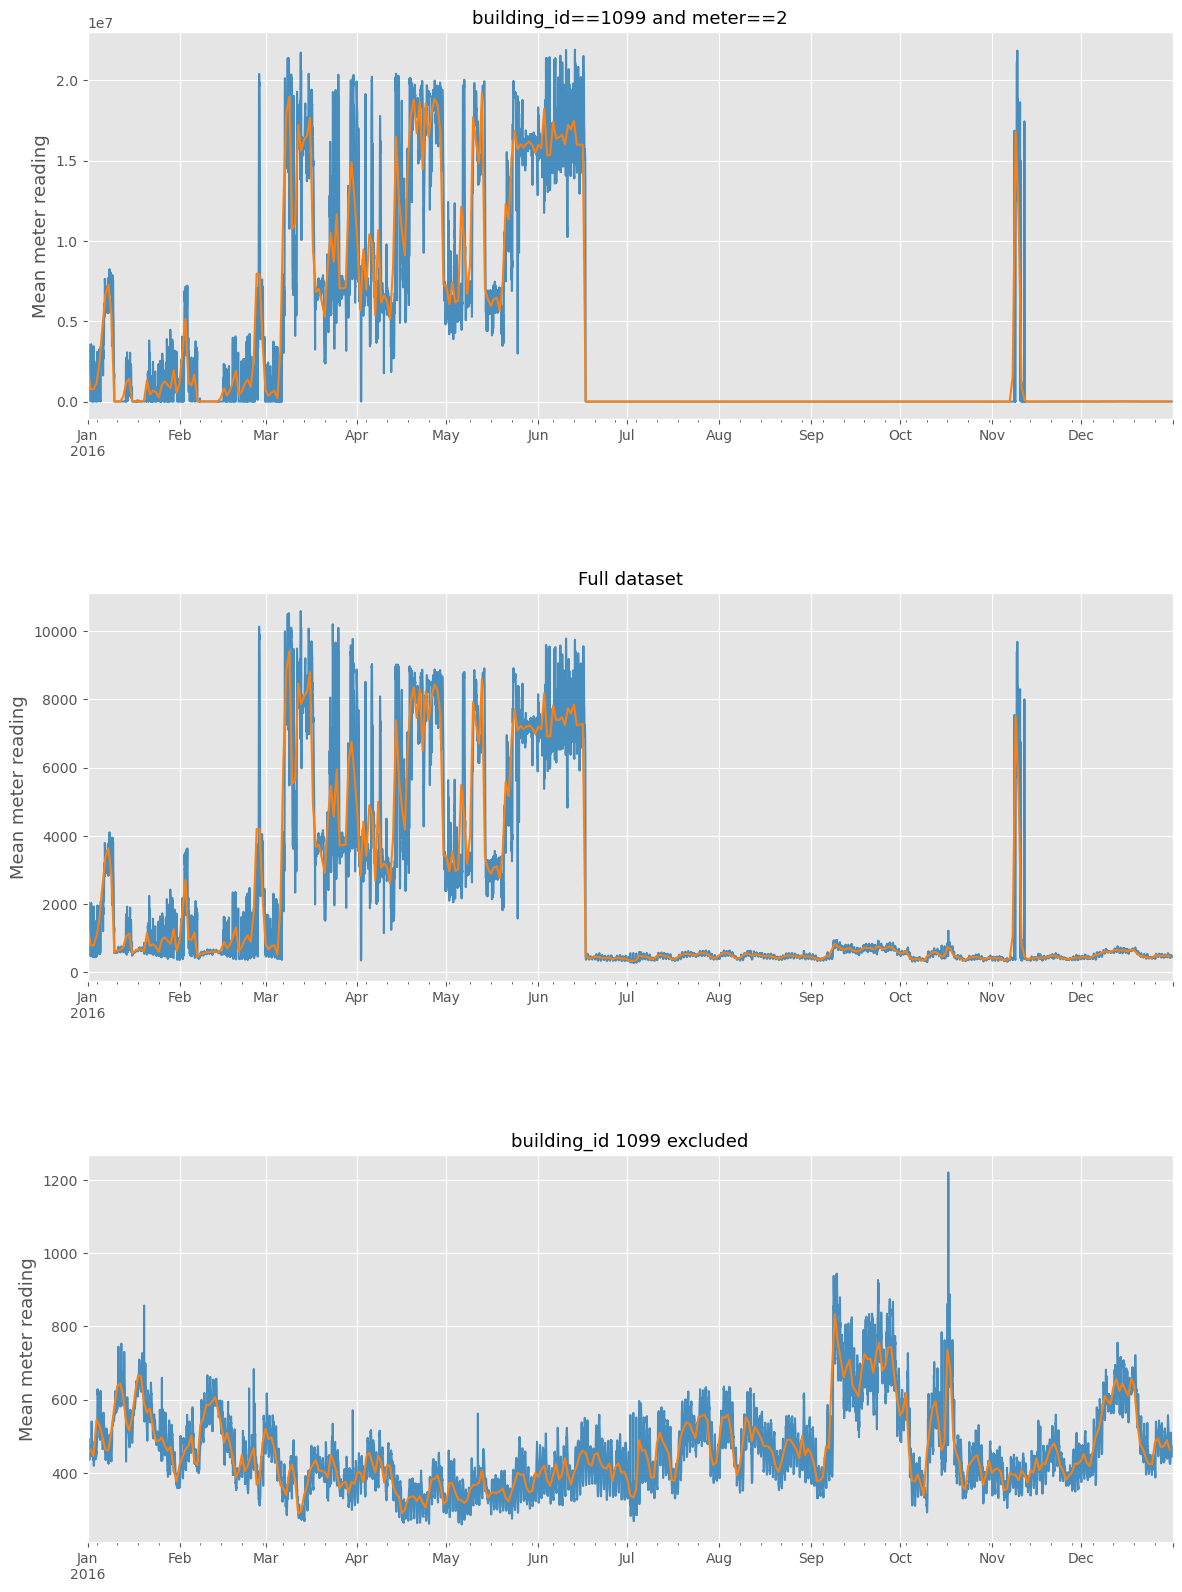

In [23]:
fig, axes = plt.subplots(3,1,figsize=(14, 20), dpi=100)

train[(train['meter'] == 2) & (train['building_id'] == 1099)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[0], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
train[(train['meter'] == 2) & (train['building_id'] == 1099)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[0], alpha=1, label='By day', color='tab:orange').set_xlabel('');

train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[1], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[1], alpha=1, label='By day', color='tab:orange').set_xlabel('');

train[~((train['meter'] == 2) & (train['building_id'] == 1099))][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[2], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
train[~((train['meter'] == 2) & (train['building_id'] == 1099))][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[2], alpha=1, label='By day', color='tab:orange').set_xlabel('');

axes[0].set_title('building_id==1099 and meter==2', fontsize=13);
axes[1].set_title('Full dataset', fontsize=13);
axes[2].set_title('building_id 1099 excluded', fontsize=13);
plt.subplots_adjust(hspace=0.45)

### Number of observations by day

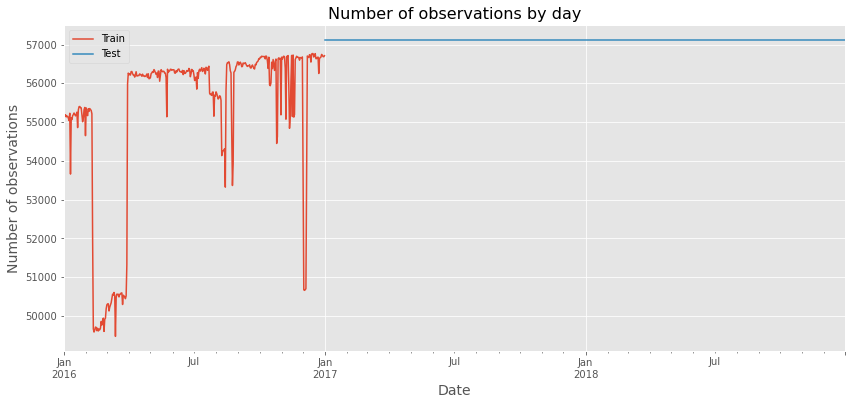

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
train['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_xlabel('Date', fontsize=14);
test['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_ylabel('Number of observations', fontsize=14);
axes.set_title('Number of observations by day', fontsize=16);
axes.legend(['Train', 'Test']);

### Meter

0: electricity, 1: chilledwater, 2: steam, hotwater: 3}

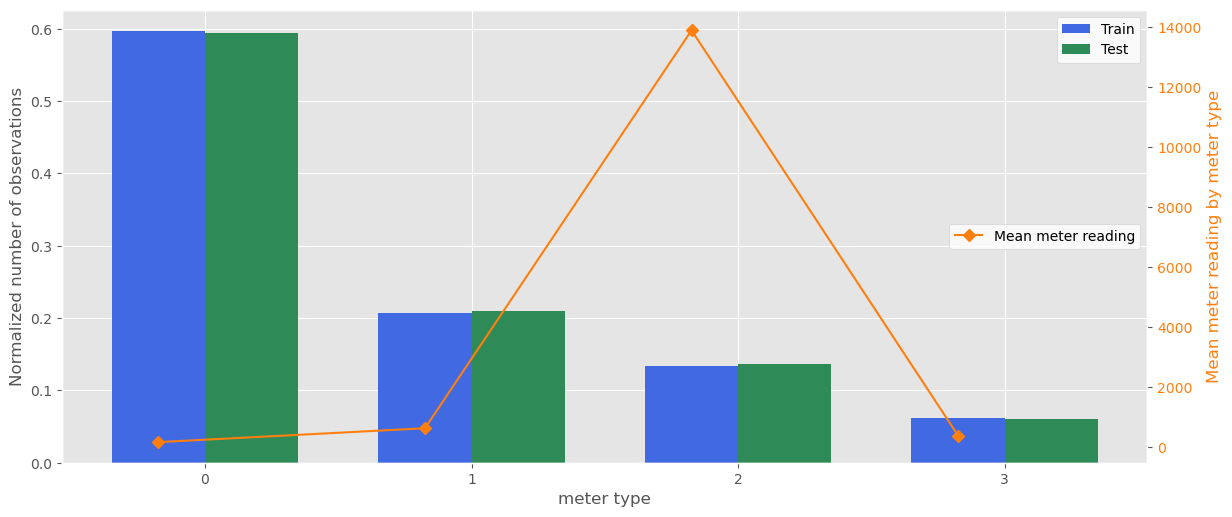

In [25]:
train_data = train['meter'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['meter'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('meter type');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['meter'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['meter', 'meter_reading']].groupby('meter')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by meter type', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=5, facecolor='white');

각 meter의 reading 값 박스플롯

<AxesSubplot:xlabel='meter', ylabel='meter_reading'>

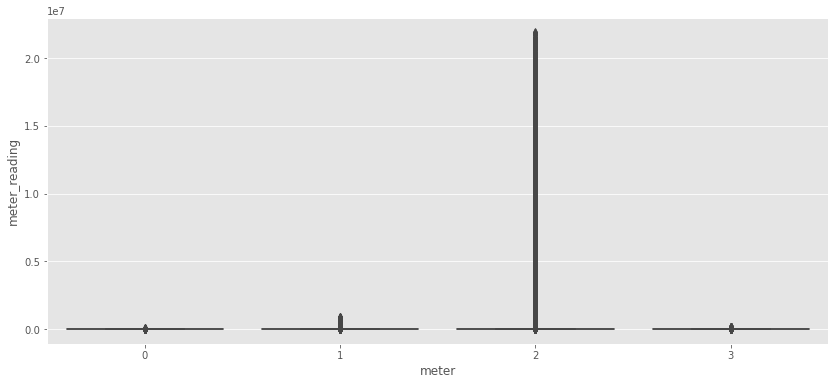

In [26]:
fig, axes = plt.subplots(1, 1, figsize = (14, 6))

sns.boxplot(x = 'meter', y = 'meter_reading', data = train)

<AxesSubplot:xlabel='meter', ylabel='meter_reading'>

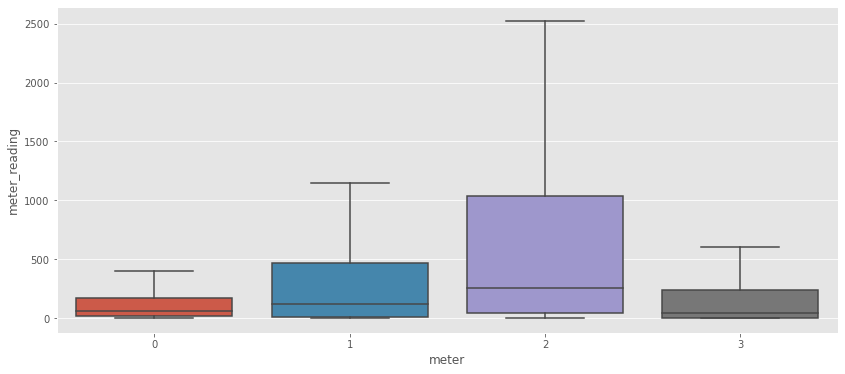

In [27]:
fig, axes = plt.subplots(1, 1, figsize = (14, 6))

sns.boxplot(x = 'meter', y = 'meter_reading', data = train, showfliers = False)

air temperature 박스플롯

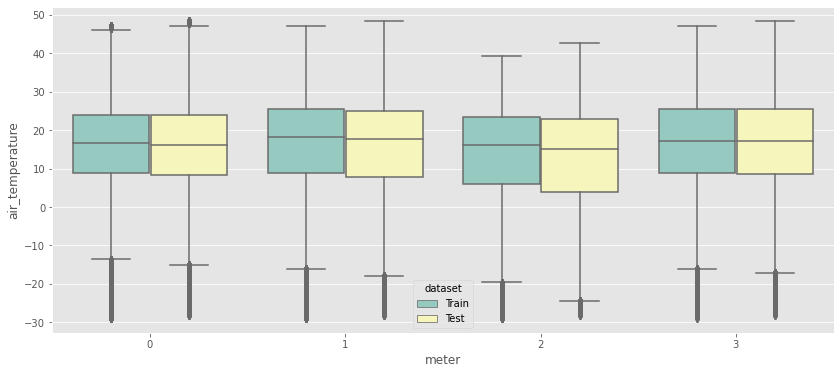

In [28]:
tmp_df = pd.concat([train[['meter', 'air_temperature']], test[['meter', 'air_temperature']]], ignore_index=True)
tmp_df['dataset'] = 'Train'
tmp_df.loc[tmp_df.index > len(train), 'dataset'] = 'Test'

fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='meter', y='air_temperature', data=tmp_df, hue='dataset', palette="Set3");

del tmp_df
gc.collect();

### site_id

site_id는 weather file과 join을 위한 foreign 키이다.

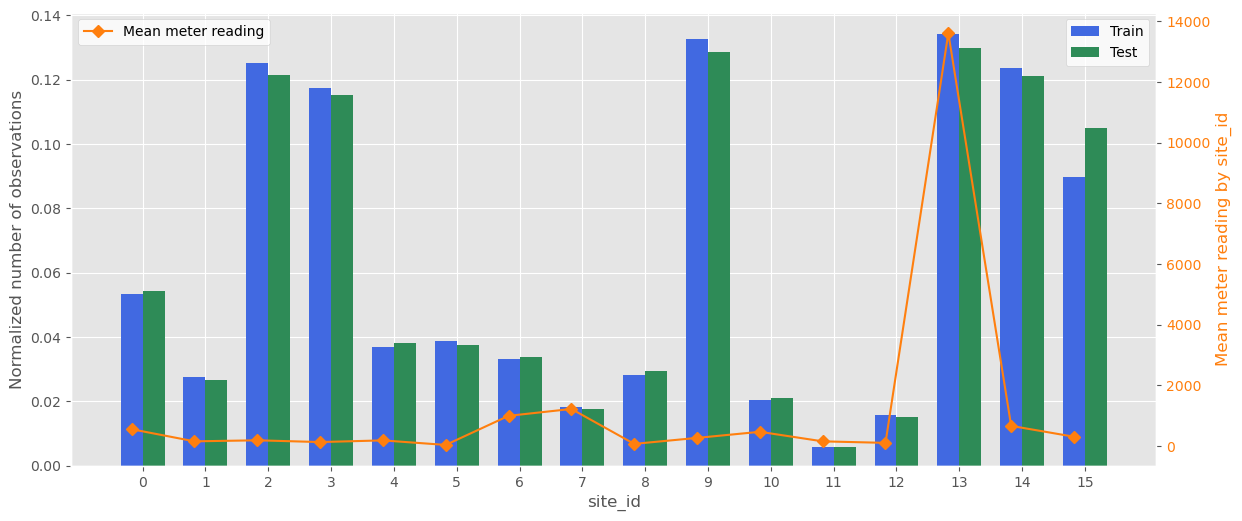

In [29]:
train_data = train['site_id'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['site_id'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('site_id');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['site_id'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['site_id', 'meter_reading']].groupby('site_id')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by site_id', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

site_id 별 reading

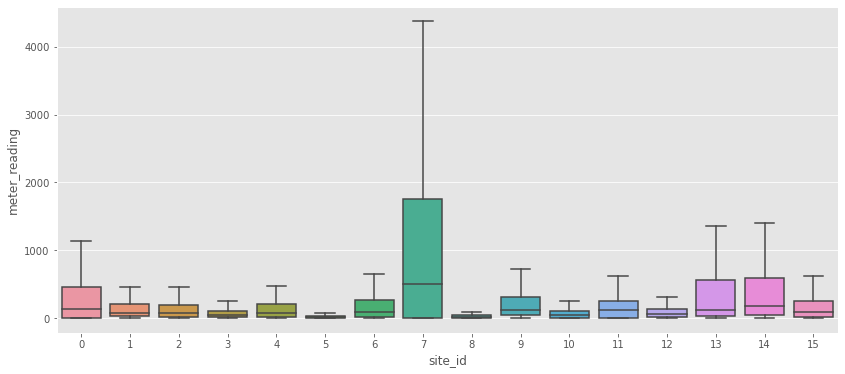

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='site_id', y='meter_reading', data=train, showfliers=False);

site_id 별 air temperature

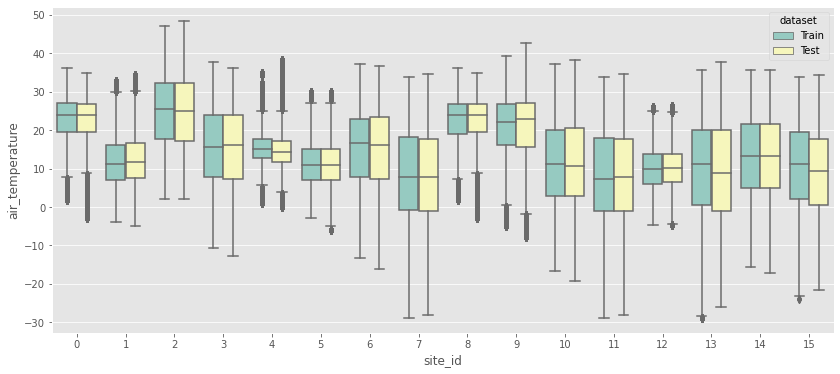

In [31]:
tmp_df = pd.concat([train[['site_id', 'air_temperature']], test[['site_id', 'air_temperature']]], ignore_index=True)
tmp_df['dataset'] = 'Train'
tmp_df.loc[tmp_df.index > len(train), 'dataset'] = 'Test'

fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='site_id', y='air_temperature', data=tmp_df, hue='dataset', palette="Set3");

del tmp_df
gc.collect();

### primary use

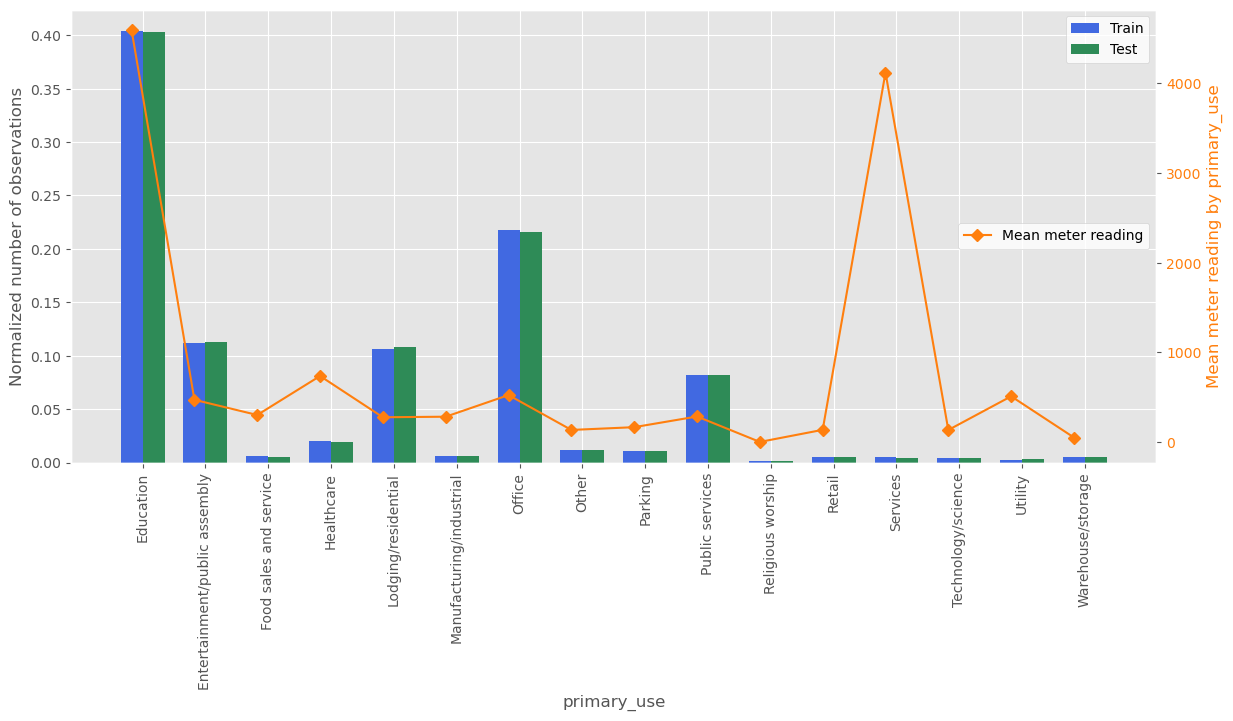

In [32]:
train_data = train['primary_use'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['primary_use'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('primary_use');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['primary_use'].value_counts().sort_index().index, rotation=90)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['primary_use', 'meter_reading']].groupby('primary_use')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by primary_use', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=5, facecolor='white');

### square_feet

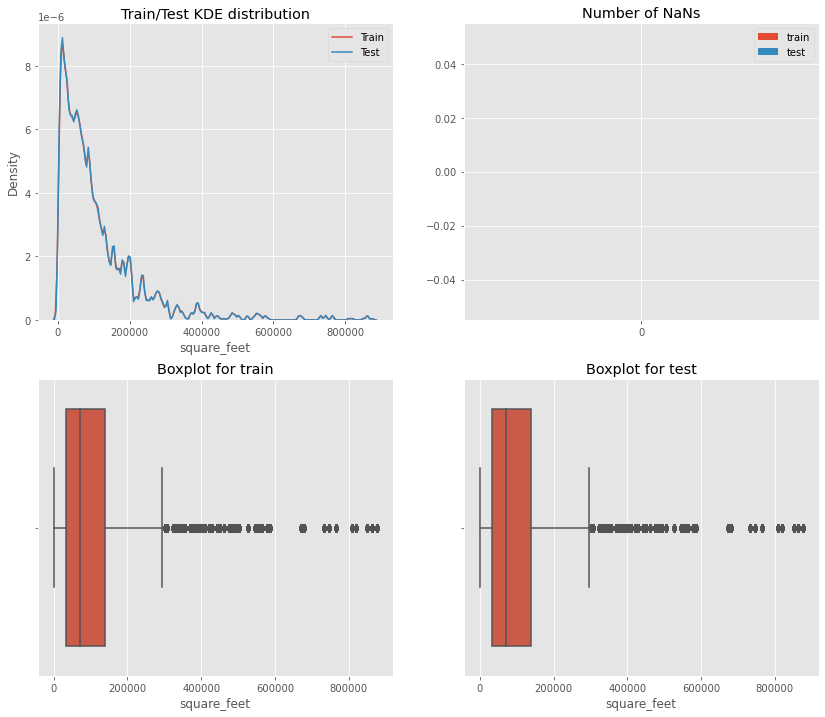

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
sns.kdeplot(train['square_feet'], ax=axes[0][0], label='Train');
sns.kdeplot(test['square_feet'], ax=axes[0][0], label='Test');
sns.boxplot(x=train['square_feet'], ax=axes[1][0]);
sns.boxplot(x=test['square_feet'], ax=axes[1][1]);
pd.DataFrame({'train': [train['square_feet'].isnull().sum()], 'test': [test['square_feet'].isnull().sum()]}).plot(kind='bar', rot=0, ax=axes[0][1]);
axes[0][0].legend();
axes[0][0].set_title('Train/Test KDE distribution');
axes[0][1].set_title('Number of NaNs');
axes[1][0].set_title('Boxplot for train');
axes[1][1].set_title('Boxplot for test');
gc.collect();

In [34]:
print(train[train['building_id'] == 0]['square_feet'].value_counts())
print(train[train['building_id'] == 1]['square_feet'].value_counts())
print(train[train['building_id'] == 100]['square_feet'].value_counts())

7432    8784
Name: square_feet, dtype: int64
2720    8784
Name: square_feet, dtype: int64
24456    8784
Name: square_feet, dtype: int64


- 각 빌딩은 유니크한 면적을 가진다.

In [35]:
train[['building_id', 'square_feet']].sort_values(by = 'building_id')

building_id  square_feet
0                   0         7432
4232656             0         7432
11161913            0         7432
13433842            0         7432
15695236            0         7432
...               ...          ...
17664532         1448        92271
7917878          1448        92271
7920222          1448        92271
7908496          1448        92271
20216099         1448        92271

[20216100 rows x 2 columns]

building_id 별 평균 미터를 확인하자.

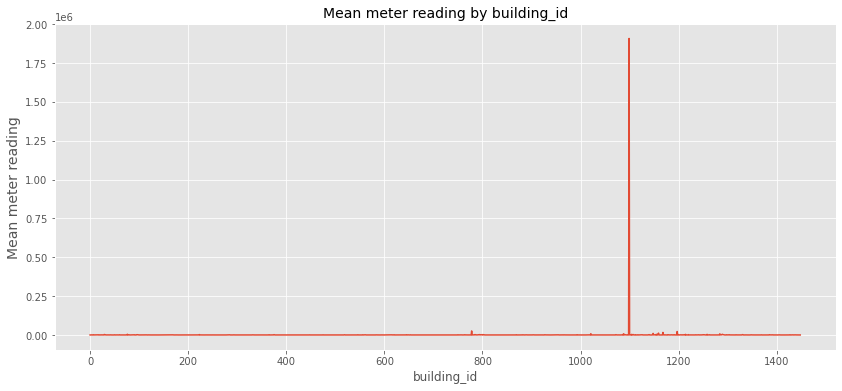

In [36]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train.groupby('building_id')['meter_reading'].mean().plot();
axes.set_title('Mean meter reading by building_id', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);

- 1099 미터에 outlier가 존재한다.

- Well, it is an educational building with no year_build or floor_count provided, so probably it is an old one.

They have a steam meter which measures such an outstanding amount of electricity used.

It seems to me that this is a really really old school with a steam heating.

앞에서 조사했던 부분인 것 같다.

In [37]:
train[(train['building_id']==1099) & (train['meter_reading'] > 3000000)]

building_id  meter           timestamp  meter_reading  site_id  \
1534             1099      2 2016-01-01 00:00:00      3241630.0       13   
3830             1099      2 2016-01-01 01:00:00      3241630.0       13   
22191            1099      2 2016-01-01 09:00:00      3554740.0       13   
24488            1099      2 2016-01-01 10:00:00      3341210.0       13   
38275            1099      2 2016-01-01 16:00:00      3009500.0       13   
...               ...    ...                 ...            ...      ...   
17345482         1099      2 2016-11-10 15:00:00     15008300.0       13   
17347844         1099      2 2016-11-10 16:00:00      5399540.0       13   
17350207         1099      2 2016-11-10 17:00:00     10357700.0       13   
17352570         1099      2 2016-11-10 18:00:00     12274400.0       13   
17420378         1099      2 2016-11-11 23:00:00     17447600.0       13   

         primary_use  square_feet  year_built  floor_count  air_temperature  \
1534       Education       332884         NaN          NaN             -8.3   
3830       Education       332884         NaN          NaN             -8.3   
22191      Education       332884         NaN          NaN             -6.7   
24488      Education       332884         NaN          NaN             -8.3   
38275      Education       332884         NaN          NaN             -6.7   
...              ...          ...         ...          ...              ...   
17345482   Education       332884         NaN          NaN              9.4   
17347844   Education       332884         NaN          NaN             11.7   
17350207   Education       332884         NaN          NaN             13.9   
17352570   Education       332884         NaN          NaN             16.1   
17420378   Education       332884         NaN          NaN              7.8   

          cloud_coverage  dew_temperature  precip_depth_1_hr  \
1534                 8.0            -12.2                NaN   
3830                 NaN            -11.7               -1.0   
22191                NaN             -9.4               -1.0   
24488                NaN            -11.7                0.0   
38275                NaN            -10.6                0.0   
...                  ...              ...                ...   
17345482             0.0              2.8                0.0   
17347844             0.0              3.3                0.0   
17350207             0.0              3.3                0.0   
17352570             0.0              4.4                0.0   
17420378             0.0             -3.3                0.0   

          sea_level_pressure  wind_direction  wind_speed  
1534             1023.299988           250.0         4.1  
3830             1023.299988           240.0         4.1  
22191            1022.000000           250.0         3.6  
24488            1021.900024           270.0         6.7  
38275            1017.900024           230.0         6.2  
...                      ...             ...         ...  
17345482         1013.799988           230.0         4.6  
17347844         1013.500000           250.0         4.6  
17350207         1013.700012           270.0         5.1  
17352570         1013.299988           270.0         4.6  
17420378         1032.099976             0.0         0.0  

[2746 rows x 16 columns]

- 그런데 위 빌딩들은 모두 site_id 13에 위치하고 있다....  

그러면 이 site에 있는 1099 빌딩을 포함한 후, 또는 제외한 후 에너지 소비량을 구해보자.   

Meter reading 값이 급격하게 변한다.

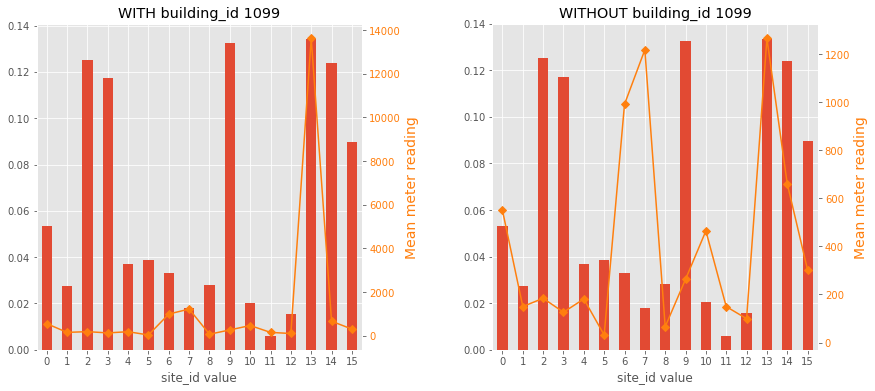

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
train['site_id'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[0]).set_xlabel('site_id value');
train[train['building_id']!=1099]['site_id'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[1]).set_xlabel('site_id value');
ax2 = axes[0].twinx()
ax3 = axes[1].twinx()
train.groupby('site_id')['meter_reading'].mean().sort_index().plot(ax=ax2, style='D-', grid=False, color='tab:orange');
train[train['building_id']!=1099].groupby('site_id')['meter_reading'].mean().sort_index().plot(ax=ax3, style='D-', grid=False, color='tab:orange');
ax2.set_ylabel('Mean meter reading', color='tab:orange', fontsize=14);
ax3.set_ylabel('Mean meter reading', color='tab:orange', fontsize=14);
ax2.tick_params(axis='y', labelcolor='tab:orange');
ax3.tick_params(axis='y', labelcolor='tab:orange');
plt.subplots_adjust(wspace=0.4)
axes[0].set_title('WITH building_id 1099');
axes[1].set_title('WITHOUT building_id 1099');

 building_id 1099를 제외하고 id 별 meter reading을 구해보자.

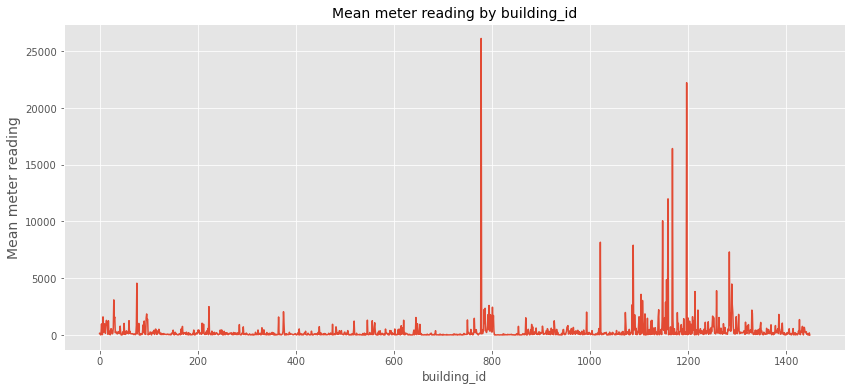

In [39]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train[train['building_id'] != 1099].groupby('building_id')['meter_reading'].mean().plot();
axes.set_title('Mean meter reading by building_id', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);

### year_built

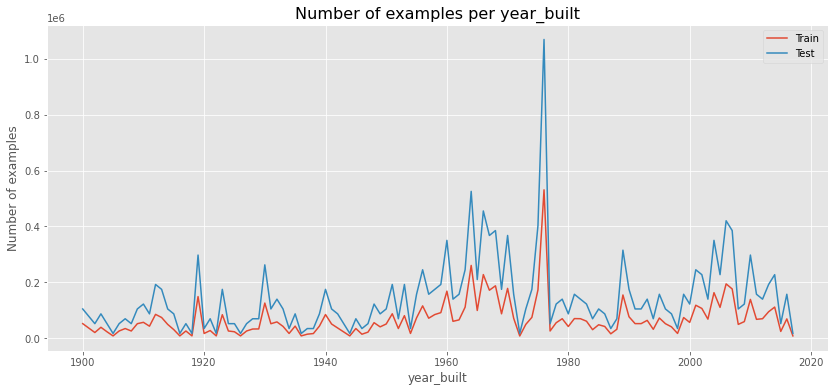

In [40]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train['year_built'].value_counts(dropna=False).sort_index().plot(ax=axes).set_xlabel('year_built');
test['year_built'].value_counts(dropna=False).sort_index().plot(ax=axes).set_ylabel('Number of examples');
axes.legend(['Train', 'Test']);
axes.set_title('Number of examples per year_built', fontsize=16);

연도별 평균 reading

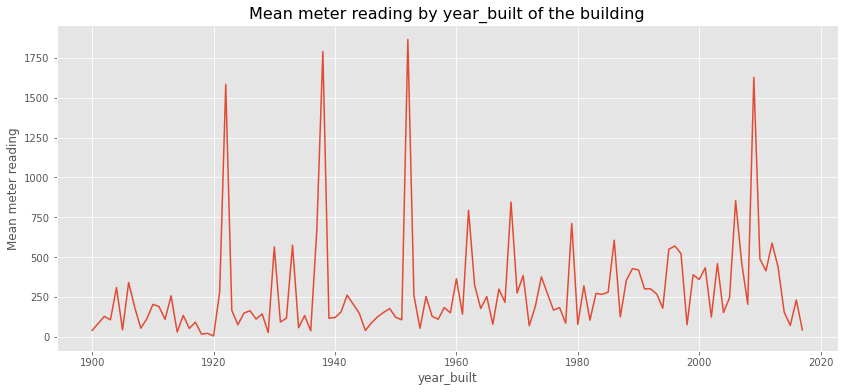

In [41]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train.groupby('year_built')['meter_reading'].mean().plot().set_ylabel('Mean meter reading');
axes.set_title('Mean meter reading by year_built of the building', fontsize=16);

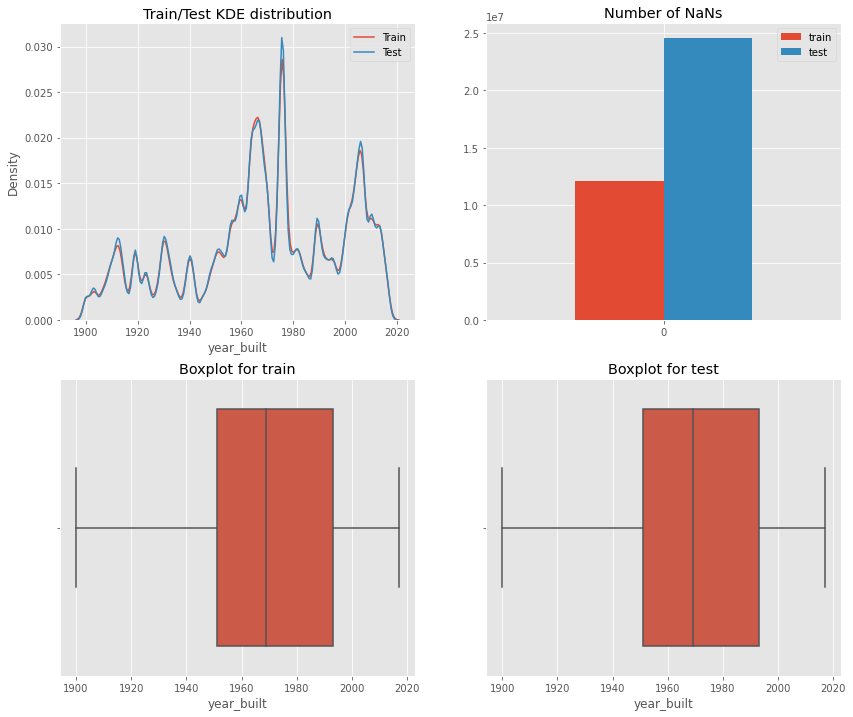

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
sns.kdeplot(train['year_built'], ax=axes[0][0], label='Train');
sns.kdeplot(test['year_built'], ax=axes[0][0], label='Test');
sns.boxplot(x=train['year_built'], ax=axes[1][0]);
sns.boxplot(x=test['year_built'], ax=axes[1][1]);
pd.DataFrame({'train': [train['year_built'].isnull().sum()], 'test': [test['year_built'].isnull().sum()]}).plot(kind='bar', rot=0, ax=axes[0][1]);
axes[0][0].legend();
axes[0][0].set_title('Train/Test KDE distribution');
axes[0][1].set_title('Number of NaNs');
axes[1][0].set_title('Boxplot for train');
axes[1][1].set_title('Boxplot for test');
gc.collect();

### floor_count

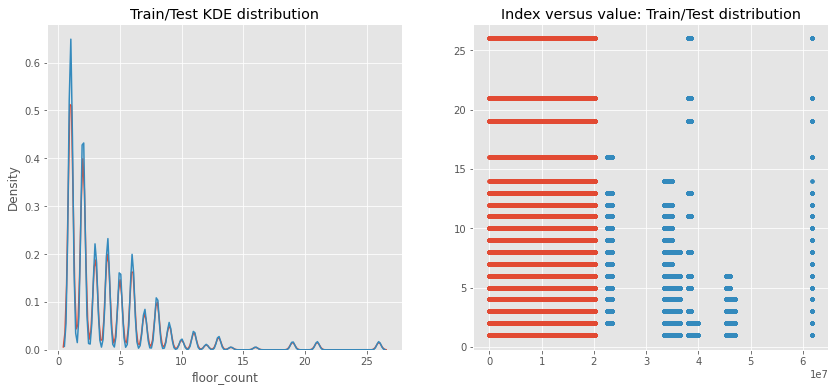

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.kdeplot(train['floor_count'], label='Train', ax=axes[0]);
sns.kdeplot(test['floor_count'], label='Test', ax=axes[0]);
test.index += len(train)
axes[1].plot(train['floor_count'], '.', label='Train');
axes[1].plot(test['floor_count'], '.', label='Test');
test.index -= len(train)
axes[0].set_title('Train/Test KDE distribution');
axes[1].set_title('Index versus value: Train/Test distribution');
gc.collect();

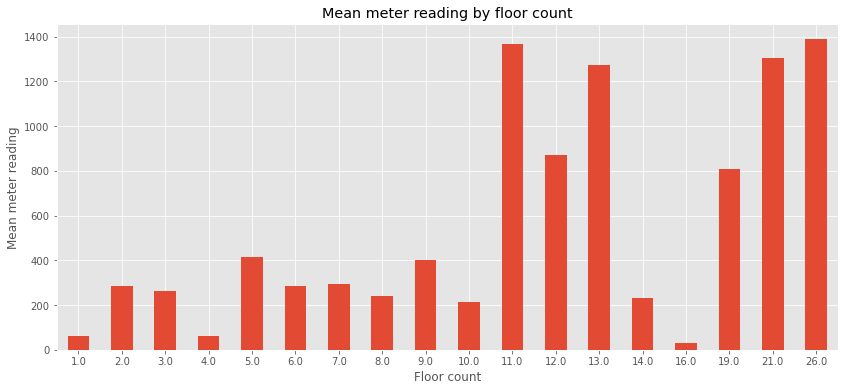

In [44]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
pd.Series(index=train['floor_count'].value_counts().index, 
          data=train.groupby('floor_count')['meter_reading'].transform('mean').value_counts().index).sort_index().plot(kind='bar', rot=0, ax=axes);
axes.set_xlabel('Floor count');
axes.set_ylabel('Mean meter reading');
axes.set_title('Mean meter reading by floor count');

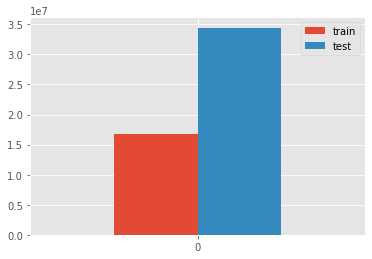

In [45]:
pd.DataFrame({'train': [train['floor_count'].isnull().sum()], 'test': [test['floor_count'].isnull().sum()]}).plot(kind='bar', rot=0);

### building_id

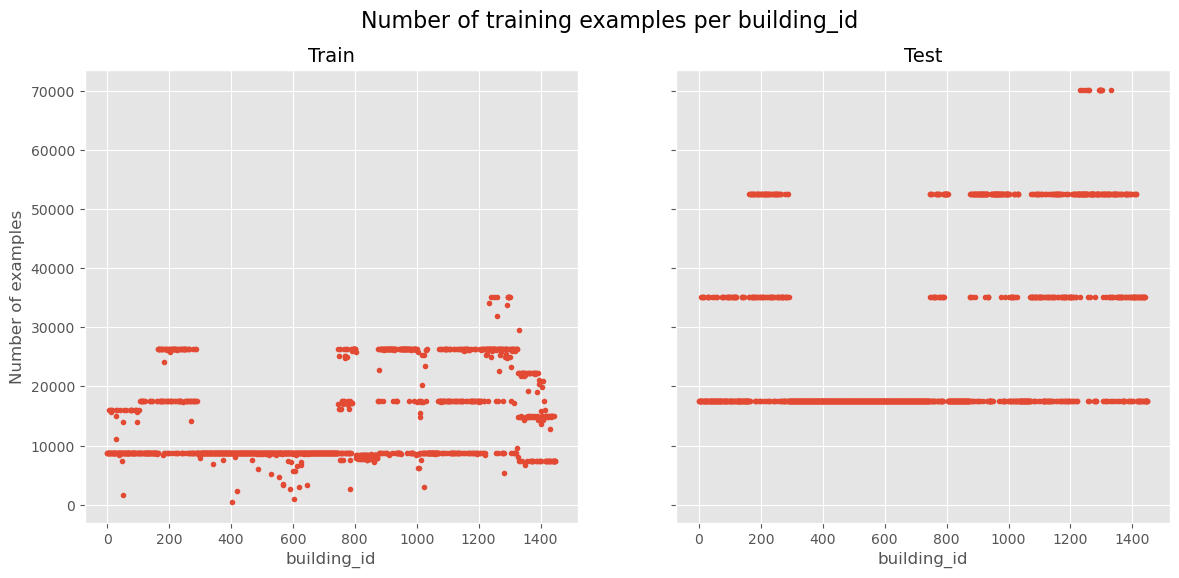

In [46]:
fig, axes = plt.subplots(1,2,figsize=(14, 6), sharey=True, dpi=100)
axes[0].plot(train['building_id'].value_counts().sort_index(), '.');
axes[1].plot(test['building_id'].value_counts().sort_index(), '.');
axes[0].set_title('Train', fontsize=14);
axes[1].set_title('Test', fontsize=14);
axes[0].set_xlabel('building_id');
axes[1].set_xlabel('building_id');
axes[0].set_ylabel('Number of examples');
fig.suptitle('Number of training examples per building_id', fontsize=16);

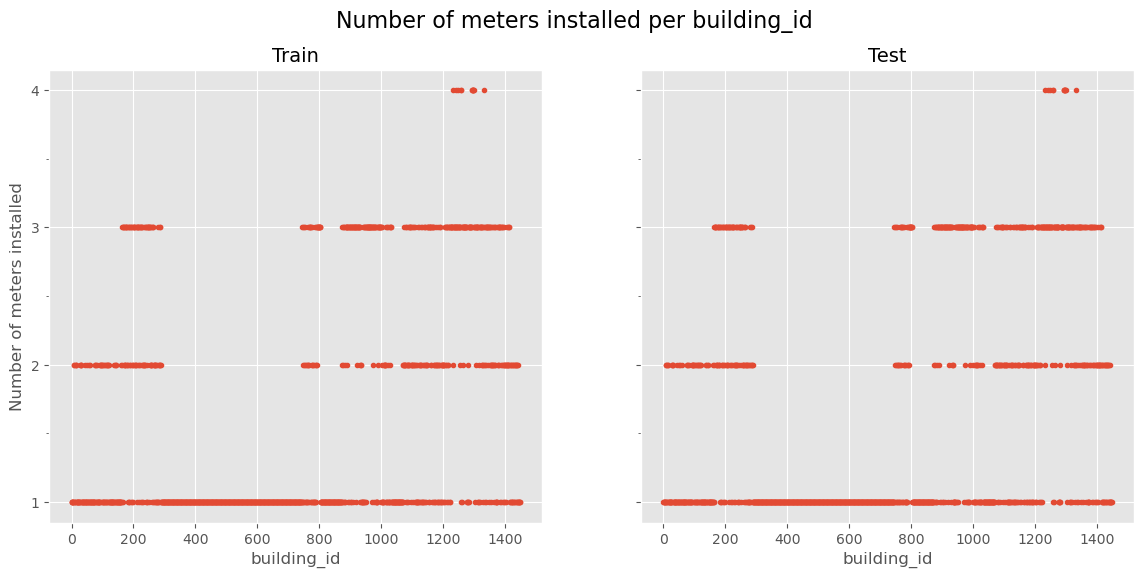

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100, sharey=True)
train.groupby('building_id')['meter'].nunique().plot(style='.', ax=axes[0]);
test.groupby('building_id')['meter'].nunique().plot(style='.', ax=axes[1]);
axes[0].set_title('Train', fontsize=14);
axes[1].set_title('Test', fontsize=14);
axes[0].set_xlabel('building_id');
axes[1].set_xlabel('building_id');
axes[0].set_ylabel('Number of meters installed');
plt.yticks([1, 2, 3, 4]);
fig.suptitle('Number of meters installed per building_id', fontsize=16);

### air_temperature

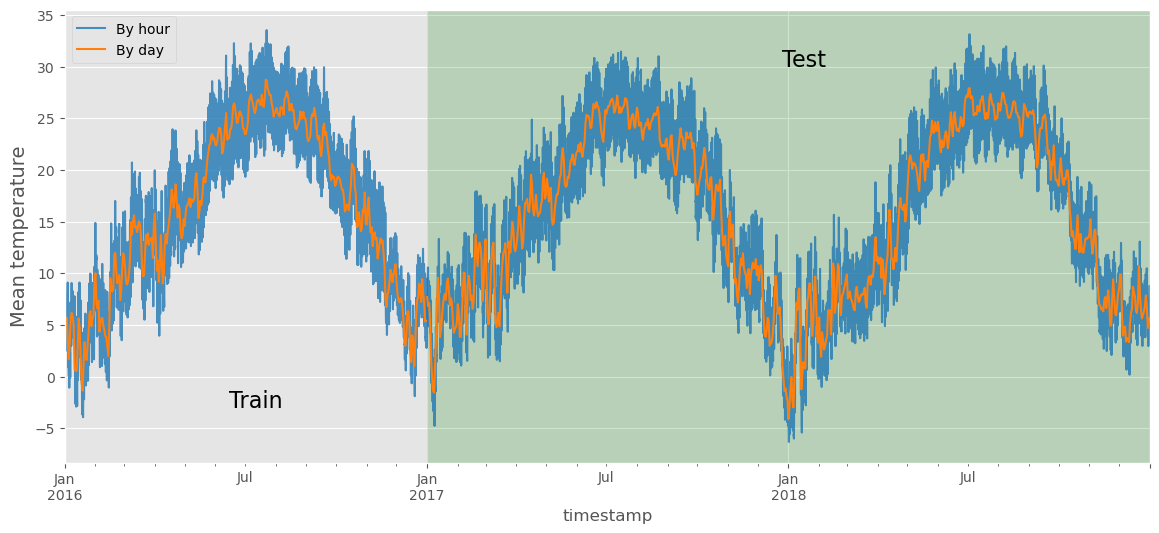

In [48]:
fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
train[['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean temperature', fontsize=14);
test[['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax=axes, alpha=0.8, color='tab:blue', label='');
train[['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax=axes, alpha=1, label='By day', color='tab:orange');
test[['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax=axes, alpha=1, color='tab:orange', label='');
axes.legend();
axes.text(train['timestamp'].iloc[9000000], -3, 'Train', fontsize=16);
axes.text(test['timestamp'].iloc[29400000], 30, 'Test', fontsize=16);
axes.axvspan(test['timestamp'].min(), test['timestamp'].max(), facecolor='green', alpha=0.2);

특정 사이트는 남쪽의 온도 경향을, 특정 사이트는 북쪽의 경향을 띈다.

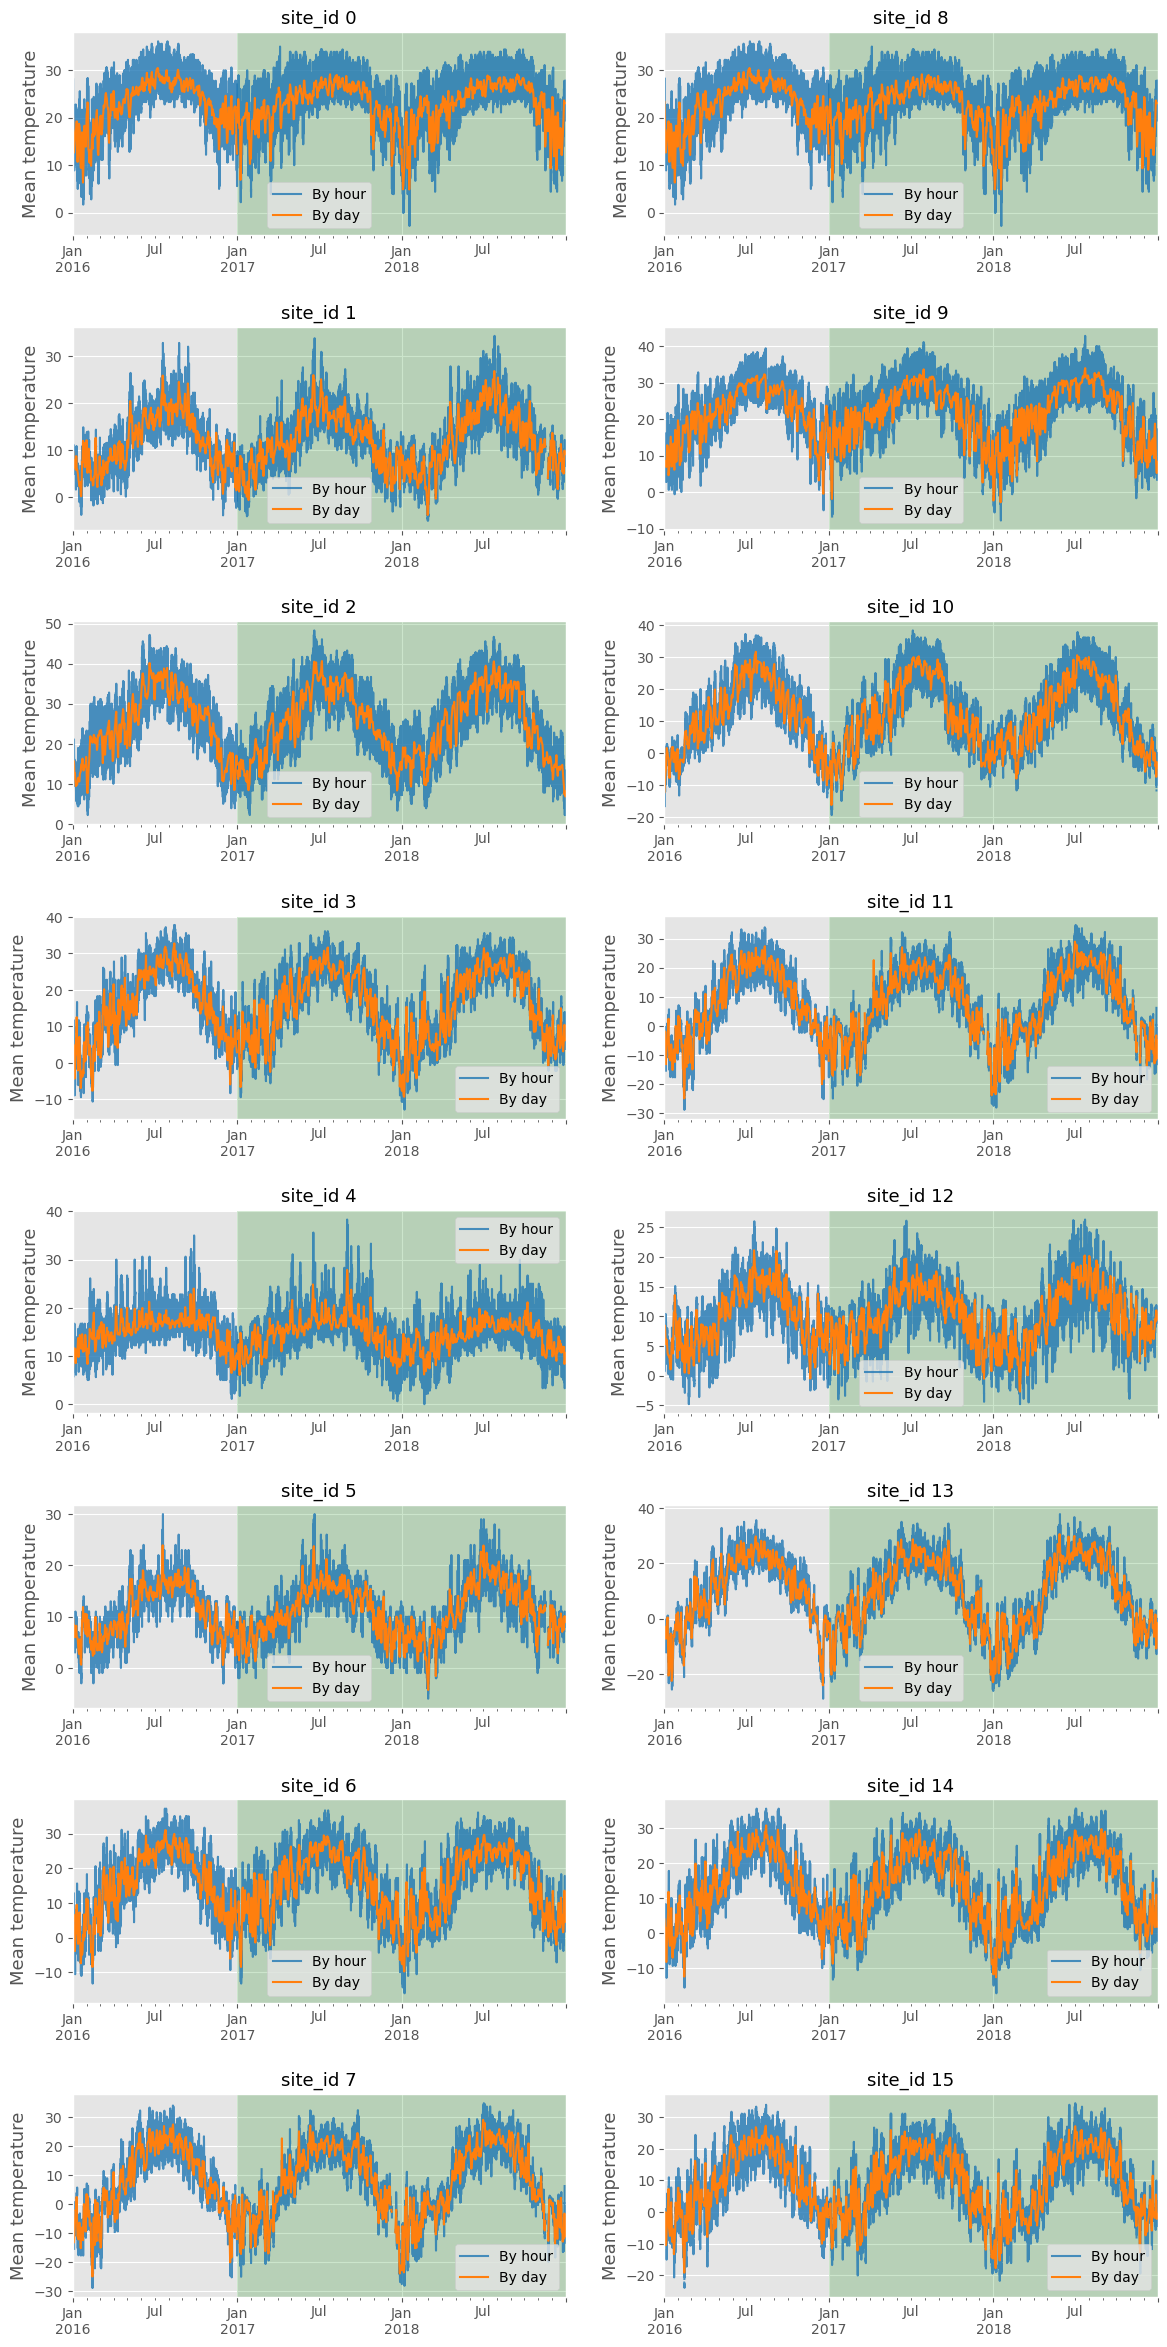

In [49]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i in range(train['site_id'].nunique()):
    train[train['site_id'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean temperature', fontsize=13);
    test[test['site_id'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('H').mean()['air_temperature'].plot(ax=axes[i%8][i//8], alpha=0.8, color='tab:blue', label='').set_xlabel('')
    train[train['site_id'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange')
    test[test['site_id'] == i][['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax=axes[i%8][i//8], alpha=1, color='tab:orange', label='').set_xlabel('')
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
    axes[i%8][i//8].axvspan(test['timestamp'].min(), test['timestamp'].max(), facecolor='green', alpha=0.2);
    plt.subplots_adjust(hspace=0.45)

### cloud_coverage

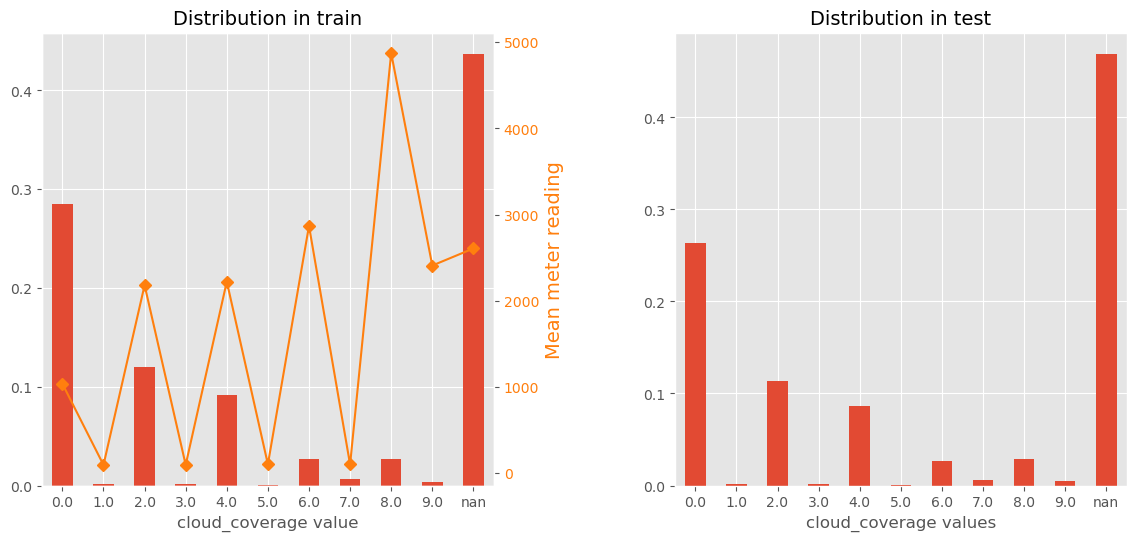

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100)
train['cloud_coverage'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[0]).set_xlabel('cloud_coverage value');
test['cloud_coverage'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[1]).set_xlabel('cloud_coverage values');
axes[0].set_title('Distribution in train', fontsize=14);
axes[1].set_title('Distribution in test', fontsize=14);
ax2 = axes[0].twinx()
train[['cloud_coverage', 'meter_reading']].replace(np.nan, 'nan').groupby('cloud_coverage')['meter_reading'].mean().plot(ax=ax2, style='D-', grid=False, color='tab:orange');
ax2.tick_params(axis='y', labelcolor='tab:orange');
ax2.set_ylabel('Mean meter reading', color='tab:orange', fontsize=14);
ax2.set_xticklabels(train['cloud_coverage'].value_counts(dropna=False).sort_index().index)
plt.subplots_adjust(wspace=0.4);

### dew_temperature

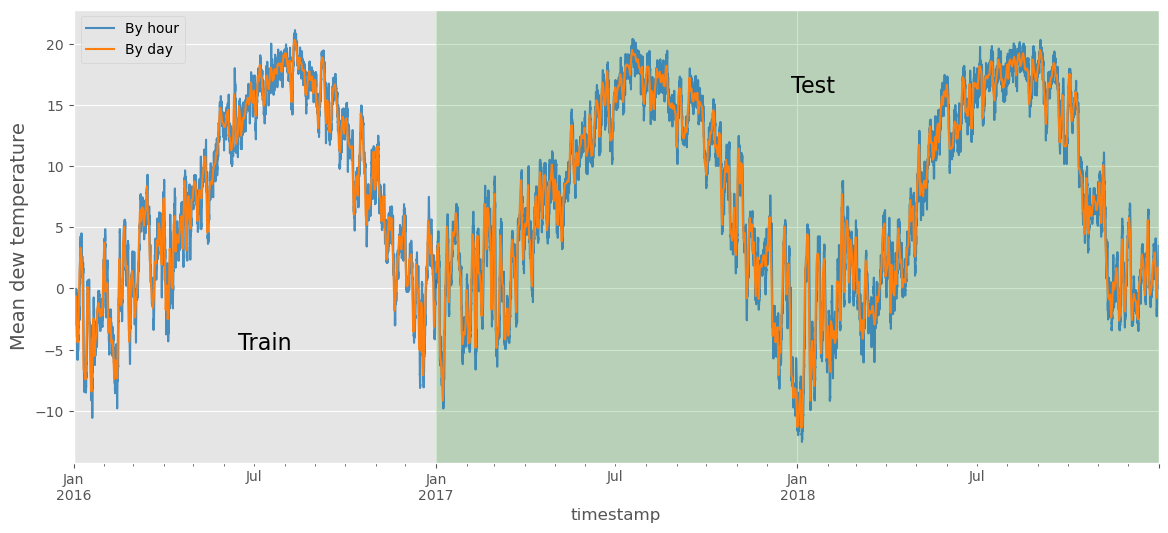

In [51]:
fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
train[['timestamp', 'dew_temperature']].set_index('timestamp').resample('H').mean()['dew_temperature'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean dew temperature', fontsize=14);
test[['timestamp', 'dew_temperature']].set_index('timestamp').resample('H').mean()['dew_temperature'].plot(ax=axes, alpha=0.8, color='tab:blue', label='');
train[['timestamp', 'dew_temperature']].set_index('timestamp').resample('D').mean()['dew_temperature'].plot(ax=axes, alpha=1, label='By day', color='tab:orange');
test[['timestamp', 'dew_temperature']].set_index('timestamp').resample('D').mean()['dew_temperature'].plot(ax=axes, alpha=1, color='tab:orange', label='');
axes.legend();
axes.text(train['timestamp'].iloc[9000000], -5, 'Train', fontsize=16);
axes.text(test['timestamp'].iloc[29400000], 16, 'Test', fontsize=16);
axes.axvspan(test['timestamp'].min(), test['timestamp'].max(), facecolor='green', alpha=0.2);

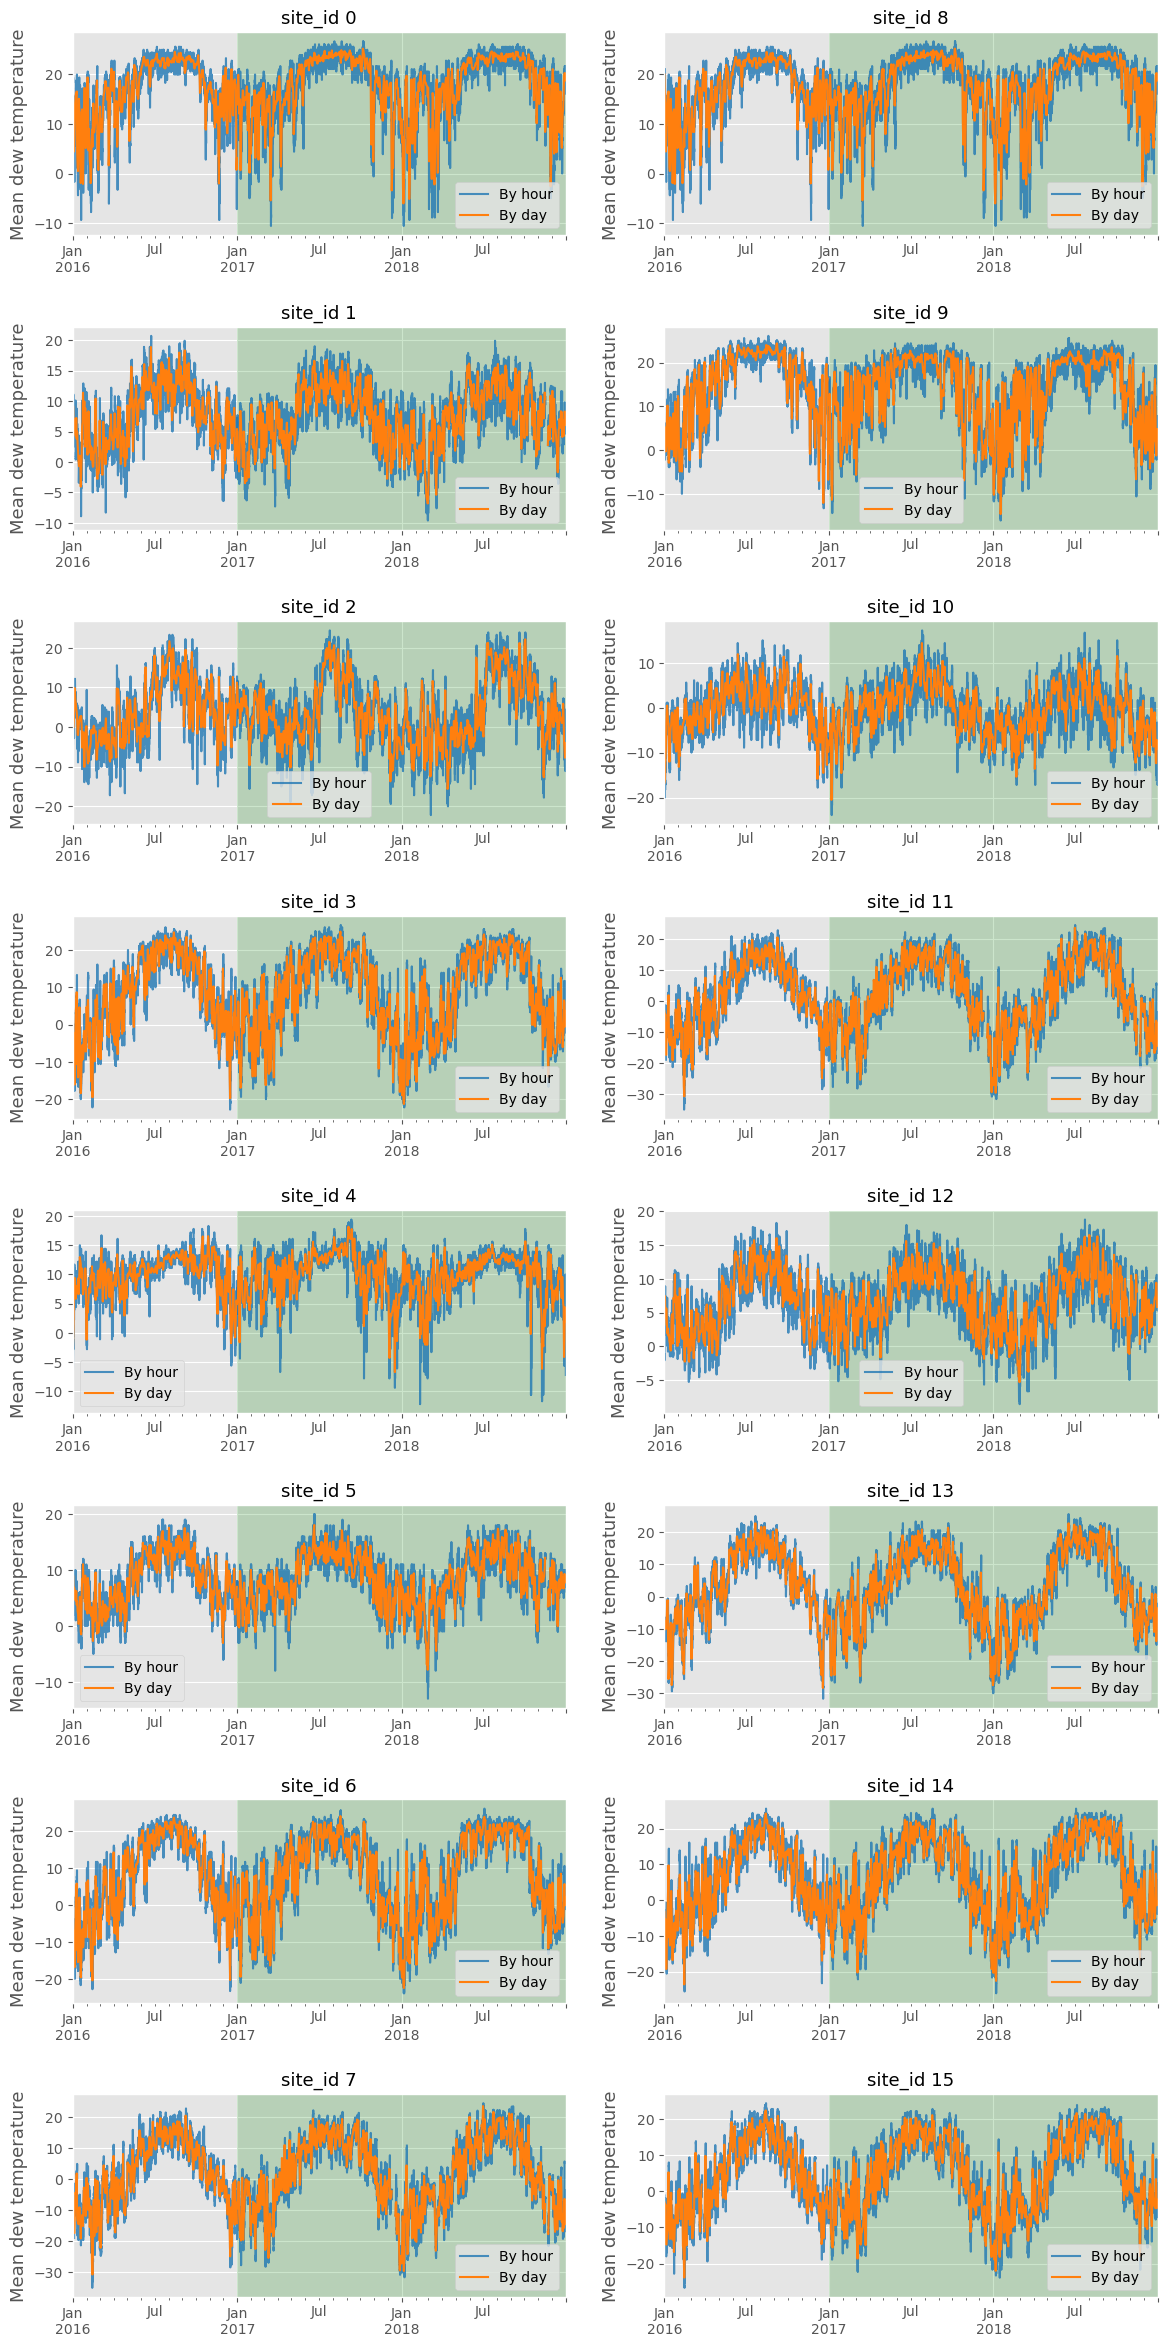

In [52]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i in range(train['site_id'].nunique()):
    train[train['site_id'] == i][['timestamp', 'dew_temperature']].set_index('timestamp').resample('H').mean()['dew_temperature'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean dew temperature', fontsize=13);
    test[test['site_id'] == i][['timestamp', 'dew_temperature']].set_index('timestamp').resample('H').mean()['dew_temperature'].plot(ax=axes[i%8][i//8], alpha=0.8, color='tab:blue', label='').set_xlabel('')
    train[train['site_id'] == i][['timestamp', 'dew_temperature']].set_index('timestamp').resample('D').mean()['dew_temperature'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange')
    test[test['site_id'] == i][['timestamp', 'dew_temperature']].set_index('timestamp').resample('D').mean()['dew_temperature'].plot(ax=axes[i%8][i//8], alpha=1, color='tab:orange', label='').set_xlabel('')
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
    axes[i%8][i//8].axvspan(test['timestamp'].min(), test['timestamp'].max(), facecolor='green', alpha=0.2);
    plt.subplots_adjust(hspace=0.45)

In [53]:
test

row_id  building_id  meter           timestamp  site_id  \
0                0            0      0 2017-01-01 00:00:00        0   
1                1            1      0 2017-01-01 00:00:00        0   
2                2            2      0 2017-01-01 00:00:00        0   
3                3            3      0 2017-01-01 00:00:00        0   
4                4            4      0 2017-01-01 00:00:00        0   
...            ...          ...    ...                 ...      ...   
41697595  41697595         1444      0 2018-05-09 07:00:00       15   
41697596  41697596         1445      0 2018-05-09 07:00:00       15   
41697597  41697597         1446      0 2018-05-09 07:00:00       15   
41697598  41697598         1447      0 2018-05-09 07:00:00       15   
41697599  41697599         1448      0 2018-05-09 07:00:00       15   

                            primary_use  square_feet  year_built  floor_count  \
0                             Education         7432      2008.0          NaN   
1                             Education         2720      2004.0          NaN   
2                             Education         5376      1991.0          NaN   
3                             Education        23685      2002.0          NaN   
4                             Education       116607      1975.0          NaN   
...                                 ...          ...         ...          ...   
41697595  Entertainment/public assembly        19619      1914.0          NaN   
41697596                      Education         4298         NaN          NaN   
41697597  Entertainment/public assembly        11265      1997.0          NaN   
41697598            Lodging/residential        29775      2001.0          NaN   
41697599                         Office        92271      2001.0          NaN   

          air_temperature  cloud_coverage  dew_temperature  precip_depth_1_hr  \
0               17.799999             4.0             11.7                NaN   
1               17.799999             4.0             11.7                NaN   
2               17.799999             4.0             11.7                NaN   
3               17.799999             4.0             11.7                NaN   
4               17.799999             4.0             11.7                NaN   
...                   ...             ...              ...                ...   
41697595              NaN             NaN              NaN                NaN   
41697596              NaN             NaN              NaN                NaN   
41697597              NaN             NaN              NaN                NaN   
41697598              NaN             NaN              NaN                NaN   
41697599              NaN             NaN              NaN                NaN   

          sea_level_pressure  wind_direction  wind_speed  
0                1021.400024           100.0         3.6  
1                1021.400024           100.0         3.6  
2                1021.400024           100.0         3.6  
3                1021.400024           100.0         3.6  
4                1021.400024           100.0         3.6  
...                      ...             ...         ...  
41697595                 NaN             NaN         NaN  
41697596                 NaN             NaN         NaN  
41697597                 NaN             NaN         NaN  
41697598                 NaN             NaN         NaN  
41697599                 NaN             NaN         NaN  

[41697600 rows x 16 columns]

### precip_depth_1_hr

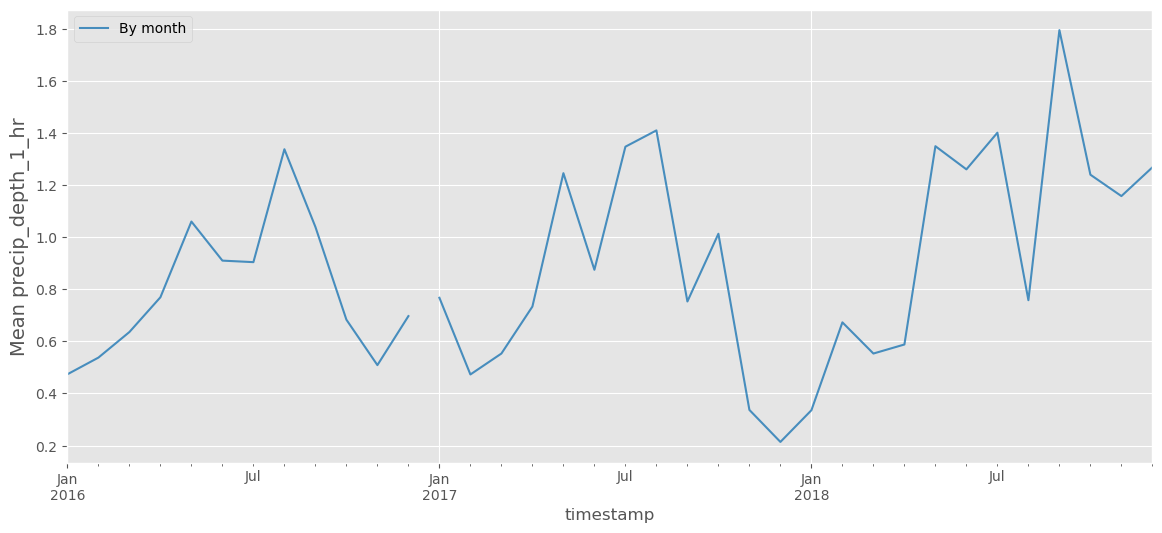

In [54]:
fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
train[['timestamp', 'precip_depth_1_hr']].set_index('timestamp').resample('M').mean()['precip_depth_1_hr'].plot(ax=axes, alpha=0.8, label='By month', color='tab:blue').set_ylabel('Mean precip_depth_1_hr', fontsize=14);
test[['timestamp', 'precip_depth_1_hr']].set_index('timestamp').resample('M').mean()['precip_depth_1_hr'].plot(ax=axes, alpha=0.8, color='tab:blue', label='');
axes.legend();

- 2016-12 ~ 2017-1 사이의 결측치가 보임

### sea_level_pressure

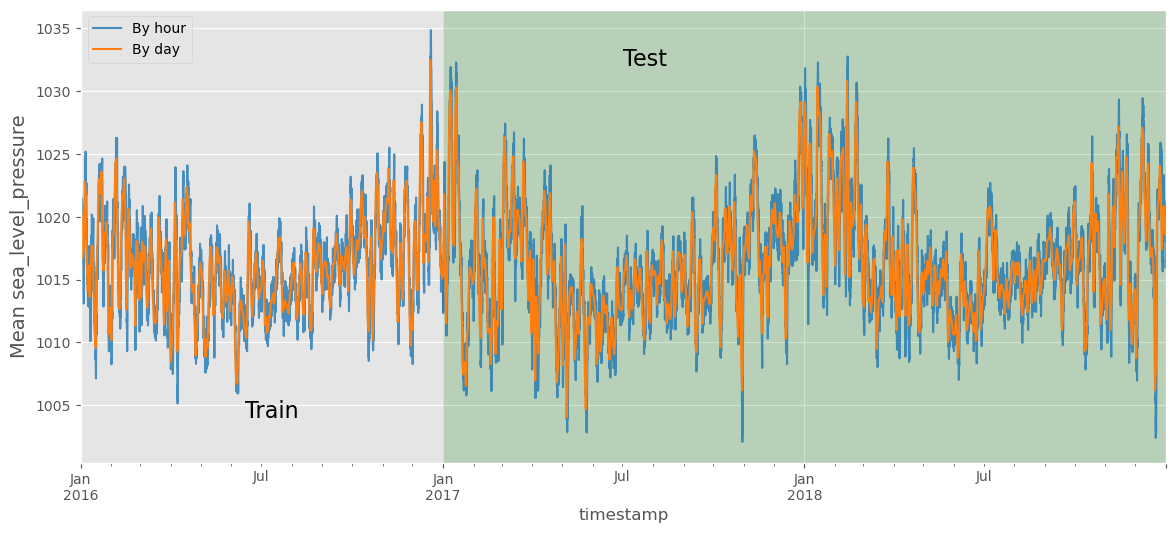

In [55]:
fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
train[['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('H').mean()['sea_level_pressure'].plot(ax=axes, alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean sea_level_pressure', fontsize=14);
test[['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('H').mean()['sea_level_pressure'].plot(ax=axes, alpha=0.8, color='tab:blue', label='');
train[['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('D').mean()['sea_level_pressure'].plot(ax=axes, alpha=1, label='By day', color='tab:orange');
test[['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('D').mean()['sea_level_pressure'].plot(ax=axes, alpha=1, color='tab:orange', label='');
axes.legend();
axes.text(train['timestamp'].iloc[9000000], 1004, 'Train', fontsize=16);
axes.text(test['timestamp'].iloc[21000000], 1032, 'Test', fontsize=16);
axes.axvspan(test['timestamp'].min(), test['timestamp'].max(), facecolor='green', alpha=0.2);

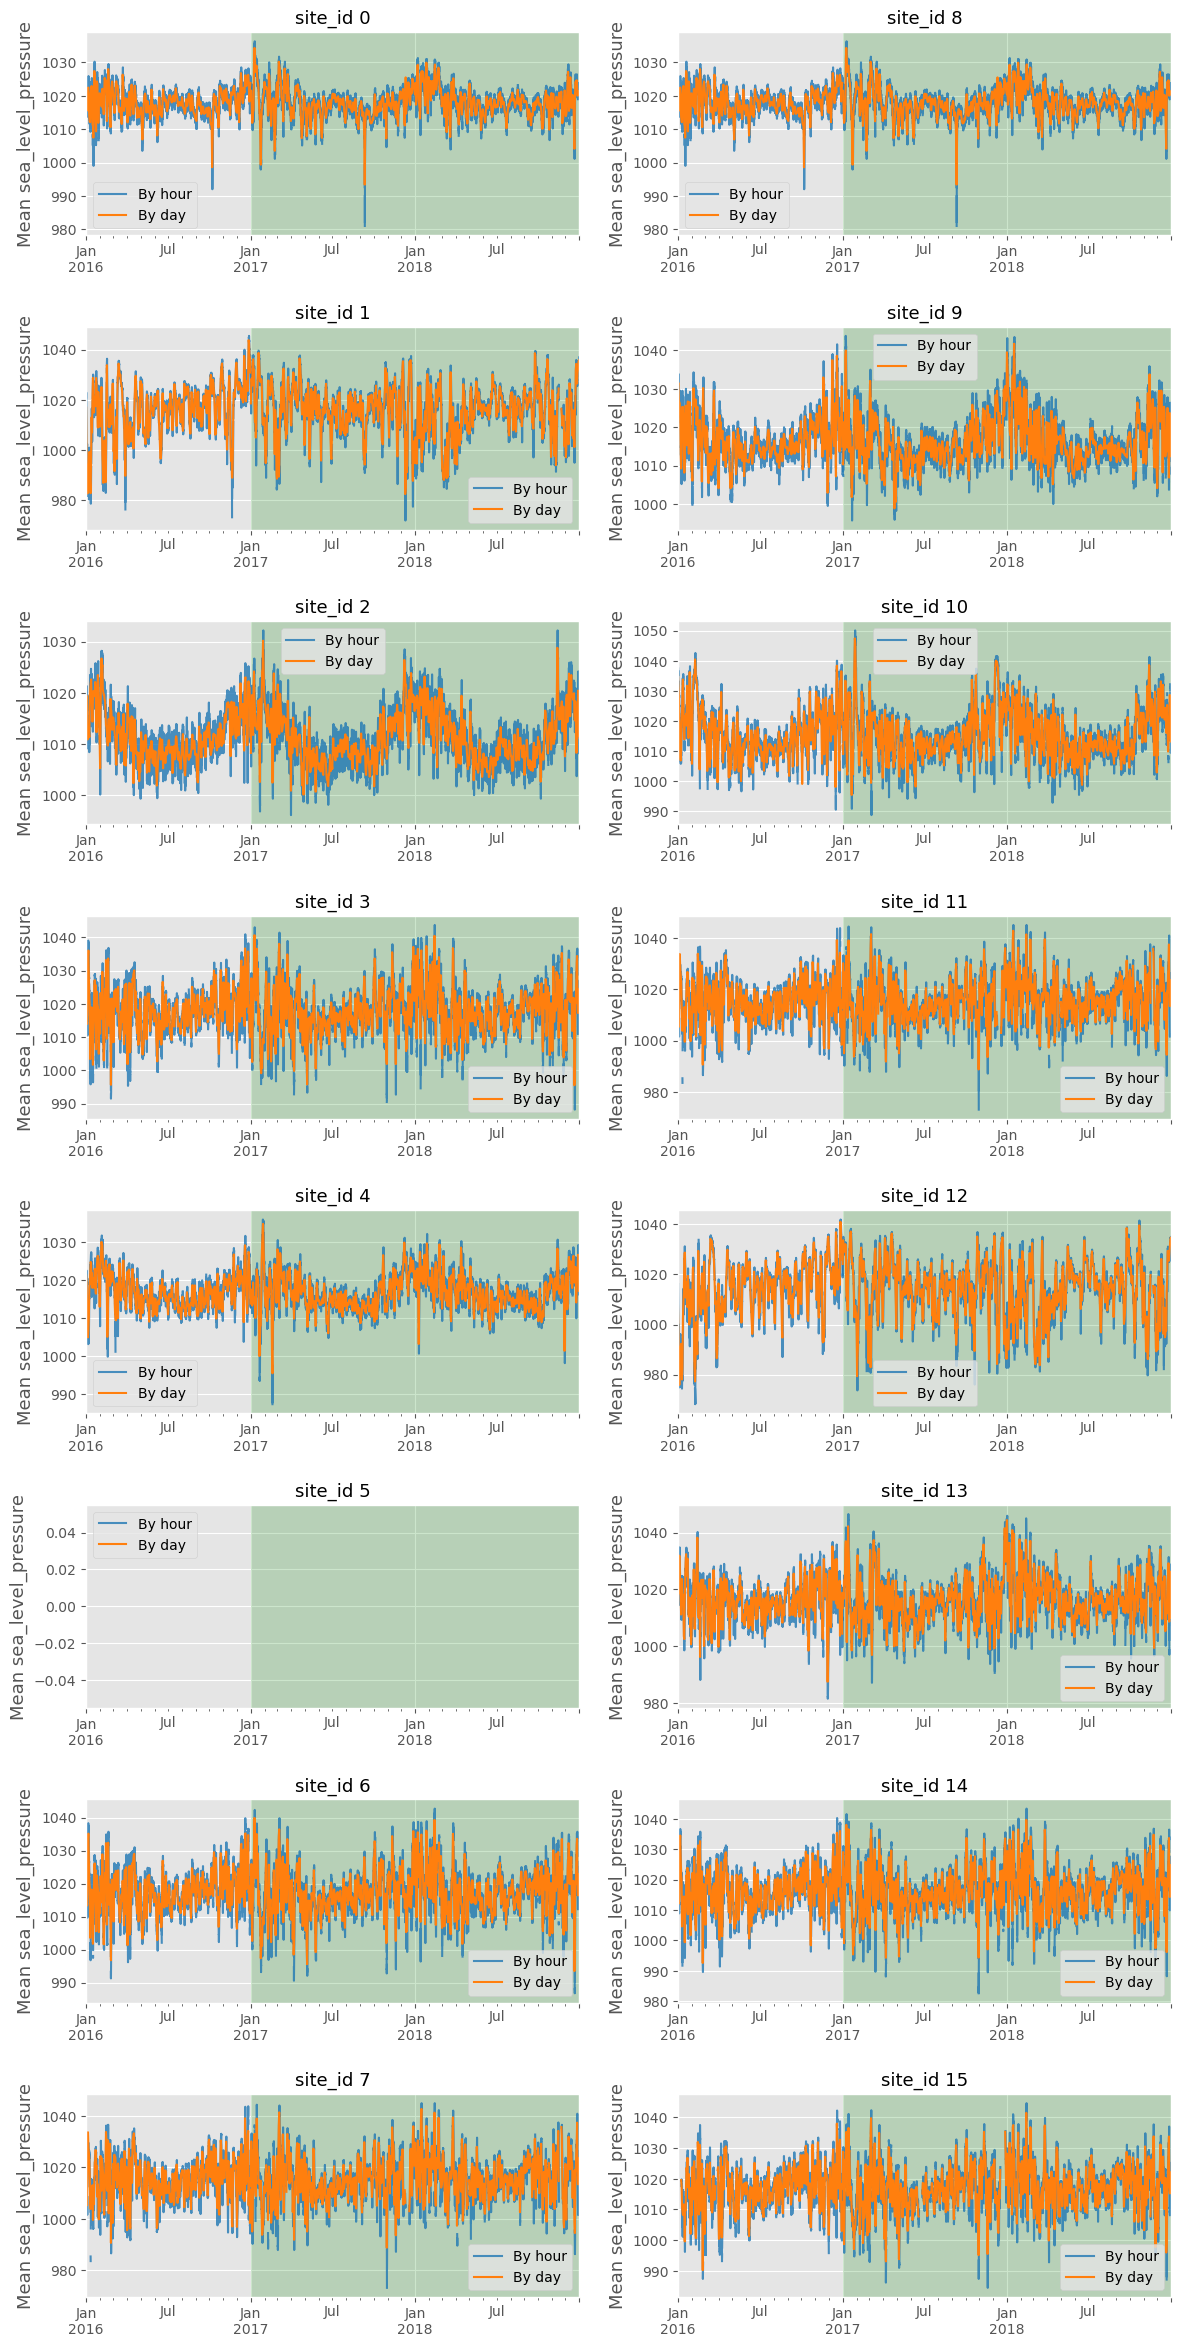

In [56]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i in range(train['site_id'].nunique()):
    train[train['site_id'] == i][['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('H').mean()['sea_level_pressure'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean sea_level_pressure', fontsize=13);
    test[test['site_id'] == i][['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('H').mean()['sea_level_pressure'].plot(ax=axes[i%8][i//8], alpha=0.8, color='tab:blue', label='').set_xlabel('')
    train[train['site_id'] == i][['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('D').mean()['sea_level_pressure'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange')
    test[test['site_id'] == i][['timestamp', 'sea_level_pressure']].set_index('timestamp').resample('D').mean()['sea_level_pressure'].plot(ax=axes[i%8][i//8], alpha=1, color='tab:orange', label='').set_xlabel('')
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
    axes[i%8][i//8].axvspan(test['timestamp'].min(), test['timestamp'].max(), facecolor='green', alpha=0.2);
    plt.subplots_adjust(hspace=0.45)


- site_id ==5에 결측치가 확인된다.

In [57]:
train[train['site_id'] == 5]['sea_level_pressure'].value_counts(dropna=False)

NaN    781776
Name: sea_level_pressure, dtype: int64

### wind_direction & wind_speed

In [58]:
print('Number of observations with 0 degree direction in TRAIN: {} ({:.2f}%)'.format(train[train['wind_direction'] == 0].shape[0], train[train['wind_direction'] == 0].shape[0] / len(train)))
print('Number of observations with 0 degree direction in TEST: {} ({:.2f}%)'.format(test[test['wind_direction'] == 0].shape[0], test[test['wind_direction'] == 0].shape[0] / len(test)))
print('Number of observations with 360 degree direction in TRAIN: {} ({:.2f}%)'.format(train[train['wind_direction'] == 360].shape[0], train[train['wind_direction'] == 360].shape[0] / len(train)))
print('Number of observations with 360 degree direction in TEST: {} ({:.2f}%)'.format(test[test['wind_direction'] == 360].shape[0], test[test['wind_direction'] == 360].shape[0] / len(test)))

Number of observations with 0 degree direction in TRAIN: 2373540 (0.12%)
Number of observations with 0 degree direction in TEST: 4796510 (0.12%)
Number of observations with 360 degree direction in TRAIN: 421533 (0.02%)
Number of observations with 360 degree direction in TEST: 813553 (0.02%)


In [59]:
print('Number of observations that have calm conditions in TRAIN: {} ({:.2f}%)'.format(train[train['wind_speed'] == 0].shape[0], train[train['wind_speed'] == 0].shape[0] / len(train)))
print('Number of observations that have calm conditions in TEST: {} ({:.2f}%)'.format(test[test['wind_speed'] == 0].shape[0], test[test['wind_speed'] == 0].shape[0] / len(test)))

Number of observations that have calm conditions in TRAIN: 2384761 (0.12%)
Number of observations that have calm conditions in TEST: 4822497 (0.12%)


In [60]:
def speed_labels(bins:list, units:str) -> list:   
    labels = list()
    for left, right in zip(bins[:-1], bins[1:]):
        if left == bins[0]:
            labels.append('calm'.format(right))
        elif np.isinf(right):
            labels.append('>{} {}'.format(left, units))
        else:
            labels.append('{} - {} {}'.format(left, right, units))
    return labels

def _convert_dir(directions, N=None):
    if N is None:
        N = directions.shape[0]
    barDir = directions * np.pi/180. - np.pi/N
    barWidth = 2 * np.pi / N
    return barDir, barWidth

spd_bins = [-1, 0, 5, 10, 15, 20, 25, 30, np.inf]
spd_labels = speed_labels(spd_bins, units='m/s')

dir_bins = np.arange(-7.5, 370, 15)
dir_labels = (dir_bins[:-1] + dir_bins[1:]) / 2

In [61]:
calm_count = train[train['wind_speed'] == 0].shape[0]
total_count = len(train)
rose = (train.assign(WindSpd_bins=lambda df:
            pd.cut(df['wind_speed'], bins=spd_bins, labels=spd_labels, right=True)).assign(WindDir_bins=lambda df: pd.cut(df['wind_direction'], bins=dir_bins, labels=dir_labels, right=False)).replace({'WindDir_bins': {360: 0}}).groupby(by=['WindSpd_bins', 'WindDir_bins']).size().unstack(level='WindSpd_bins').fillna(0).assign(calm=lambda df: calm_count / df.shape[0]).sort_index(axis=1).applymap(lambda x: x / total_count * 100))
rose.drop(rose.index[0], inplace=True)
directions = np.arange(0, 360, 15)

In [62]:
def wind_rose(rosedata, wind_dirs, palette=None):
    if palette is None:
        palette = sns.color_palette('inferno', n_colors=rosedata.shape[1])

    bar_dir, bar_width = _convert_dir(wind_dirs)

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')

    for n, (c1, c2) in enumerate(zip(rosedata.columns[:-1], rosedata.columns[1:])):
        if n == 0:
            # first column only
            ax.bar(bar_dir, rosedata[c1].values, 
                   width=bar_width,
                   color=palette[0],
                   edgecolor='none',
                   label=c1,
                   linewidth=0)

        # all other columns
        ax.bar(bar_dir, rosedata[c2].values, 
               width=bar_width, 
               bottom=rosedata.cumsum(axis=1)[c1].values,
               color=palette[n+1],
               edgecolor='none',
               label=c2,
               linewidth=0)

    leg = ax.legend(loc=(0.75, 0.95), ncol=2)
    xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    
    return fig

ValueError: shape mismatch: objects cannot be broadcast to a single shape

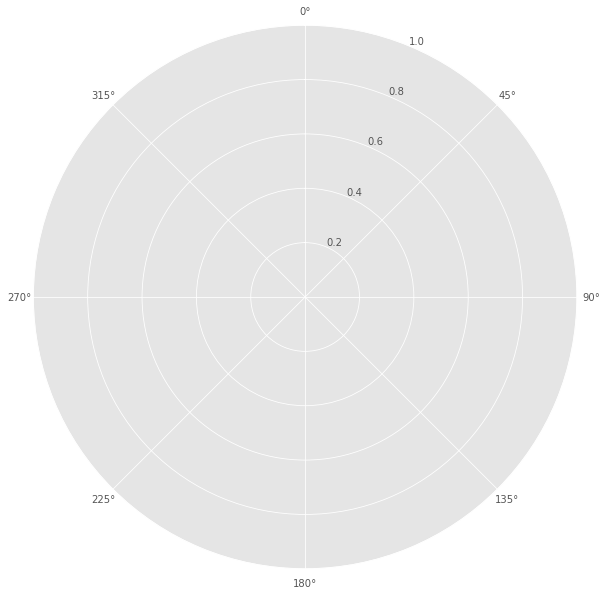

In [63]:
fig = wind_rose(rose, directions)

In [ ]:
calm_count = test[test['wind_speed'] == 0].shape[0]
total_count = len(test)
rose = (test.assign(WindSpd_bins=lambda df:
            pd.cut(df['wind_speed'], bins=spd_bins, labels=spd_labels, right=True)).assign(WindDir_bins=lambda df: pd.cut(df['wind_direction'], bins=dir_bins, labels=dir_labels, right=False)).replace({'WindDir_bins': {360: 0}}).groupby(by=['WindSpd_bins', 'WindDir_bins']).size().unstack(level='WindSpd_bins').fillna(0).assign(calm=lambda df: calm_count / df.shape[0]).sort_index(axis=1).applymap(lambda x: x / total_count * 100))
rose.drop(rose.index[0], inplace=True)

In [ ]:
fig = wind_rose(rose, directions)


### Engineered features

관측시간

In [ ]:
train['hour'] = train['timestamp'].dt.hour
test['hour'] = test['timestamp'].dt.hour

In [ ]:
train_data = train['hour'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['hour'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('Hour');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['hour'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['hour', 'meter_reading']].groupby('hour')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by hour', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

관측 월

In [64]:
train['day'] = train['timestamp'].dt.day
test['day'] = test['timestamp'].dt.day

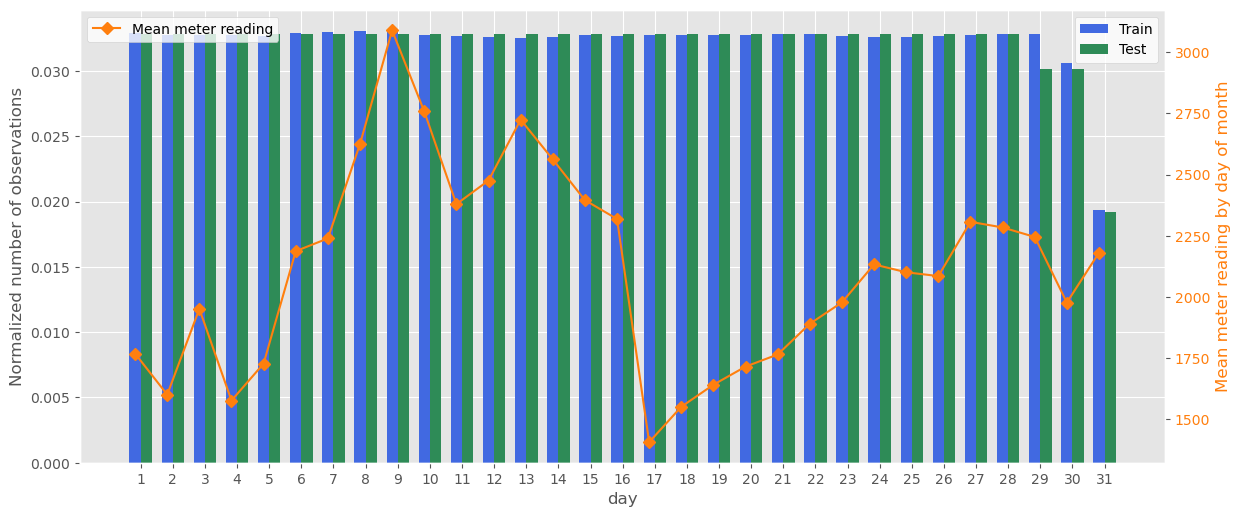

In [65]:
train_data = train['day'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['day'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('day');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['day'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['day', 'meter_reading']].groupby('day')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by day of month', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

관측 요일

In [66]:
train['weekday'] = train['timestamp'].dt.weekday
test['weekday'] = test['timestamp'].dt.weekday

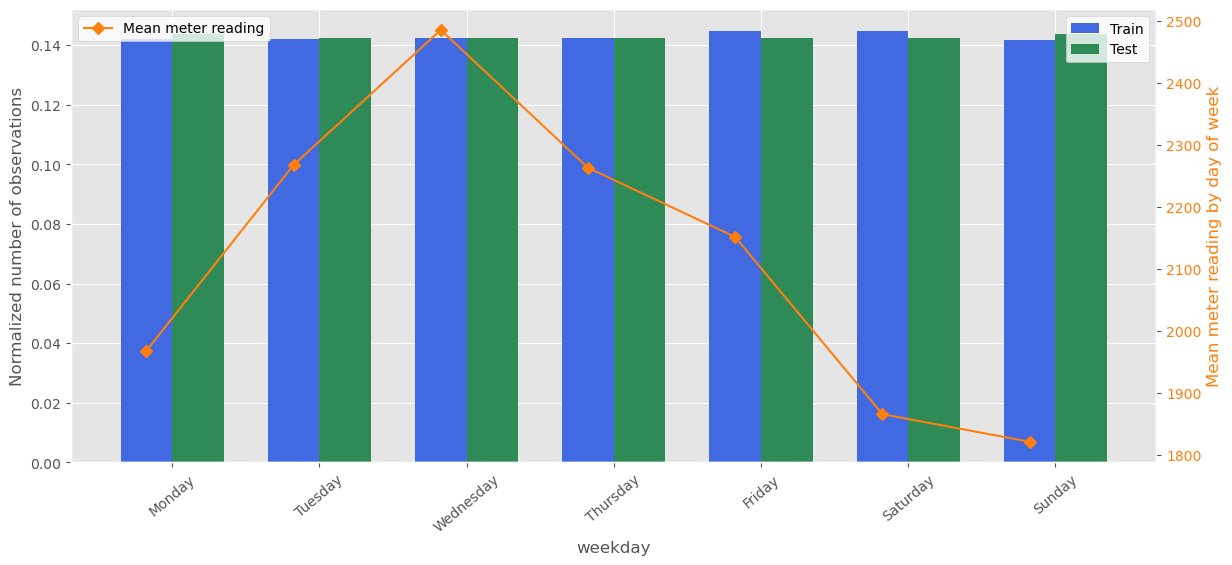

In [67]:
train_data = train['weekday'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = test['weekday'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('weekday');
axes.set_xticks(ind + width / 2)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['weekday', 'meter_reading']].groupby('weekday')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by day of week', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

axes.set_xticklabels(train['weekday'].value_counts().sort_index().index.map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}), rotation=40);